# COVID-19 Vaccination and Mask Compliance in the United States

# Overview

In the early days of the COVID-19 pandemic, the infection rates and death rates were extremely high, resulting in hospitals reaching their capacity and medical supplies becoming low. In order to reduce the infection and death rates of Americans, the CDC highly recommended that people wear mask in order to reduce to likelyhood of contracting COVID. With the first vaccines granted Emergency Use Authorization in early 2021, Americans are slowly getting vaccinated, however some people argue that COVID is a hoax and is not as infectious or deadly as the media portrays it to be. These people do not belief in wearing mask to reduce the infection rate of COVID and do not believe in the COVID vaccine.

Our project aims to explore the relationship between a state's progress with COVID-19 vaccine administration and its citizens' beliefs about mask compliance. We hypothesized that there would be a significant relationship between mask compliance and the progress of vaccinations: states that do comply to mask usage will have higher rates of vaccinations compared to states that don't wear masks. However, through regression models and choropleth maps, we found that this was in fact not true and there isn't a significant relationship between the two. 

# Names

- Alexandra Andreiu
- Willie Chow
- Catherine Dinh
- Steve Kuk
- Zachary Nguyen

<a id='research_question'></a>
# Research Question

In the United States, is there a relationship between the progress of COVID-19 state vaccinations and beliefs about mask compliance by the citizens of that state?

# Background and Pior Work

A new strain of coronavirus that nobody has previously seen in humans was first identified in Wuhan, China in December 2019. Originally referred to as “2019 novel coronavirus”, the World Health Organization (WHO) officially named the disease as coronavirus disease 2019 abbreviated as COVID-19 where “CO” stands for corona, “VI” for virus, and ”D” for disease [4]. What many thought to be a small, harmless virus has turned into a global pandemic causing more than 3 million deaths [5] and a year long and ongoing quarantine. Due to the novelty of the coronavirus, scientists are still learning about the causes and effects of the virus. Vaccines have been made and given emergency use due to the severity of COVID-19. The vaccine currently is showing positive effects on reducing COVID-19 cases globally, however there are some that still question the safety and validity of these vaccines.     

Surprisingly the anti-vaccine or anti-vaxxing movement stems back from the discovery of the first vaccine in the 18th century [1]. With the rise of COVID-19 and the mandate of masks in many states, anti-mask movements have increased taking the spotlight of anti-vaccination. Anti-maskers express similar concerns as their anti-vaccine brethren citing “that masks are damaging to the wearer’s health, causing hyperventilation and limiting oxygen intake; that masks are ineffective and do little to stop the virus; that mandating masks is authoritarian and un-American; and that COVID is not a dangerous disease” [2]. Previous studies [3] show that the negative attitudes of anti-masker is correlated with political conservatism and the denial of the seriousness of the COVID-19 pandemic and virus.
  
References:
1. https://www.verywellhealth.com/history-anti-vaccine-movement-4054321 
2. https://biomedicalodyssey.blogs.hopkinsmedicine.org/2020/09/anti-vax-to-anti-mask-processing-anti-science-claims-during-a-pandemic/ 
3. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7888611/ 
4. https://www.cdc.gov/coronavirus/2019-ncov/faq.html 
5. https://covid19.who.int/ 

# Hypothesis

We hypothesize that in states where citizens comply to mask mandates, there should be greater progress in vaccine administration compared to other states where citizens don’t follow mask mandates. We hypothesize this to be true because those who don’t believe in the efficacy of mask usage or the severity of the pandemic will most likely be skeptical, or even refuse, to get the vaccine, thus slowing progression of state vaccinations.

# Dataset(s)

**Dataset Name:** USA COVID 19 Vaccination <br>
**Link to the dataset:** https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv <br>
**Number of observations:** 9058 <br>
**Description:** A dataset published by Our World in Data, who obtain their data from the CDC. The dataset includes daily state-by-state vaccination updates in the U.S., with each observation listing the location, date, total and daily vaccinations (and per hundred), the number of people vaccinated, and more. 

**Dataset Name:** Mask-Wearing Survey Data <br>
**Link to the dataset:** https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county.csv <br>
**Number of observations:** 3142 <br>
**Description:** A dataset published by the New York Times of estimates of mask usage by county in the United States; data was obtained from conducted online surveys (from the Dynata firm) which recieved about 250,000 responses. This survey asked "How often do you wear a mask in public when you expect to be within six feet of another person?" and the answers range from: never, rarely, sometimes, frequently, and always.

**Dataset Name:** County and State FIPS Codes <br>
**Link to the dataset:** https://raw.githubusercontent.com/kjhealy/fips-codes/master/county_fips_master.csv <br>
**Number of observations:** 3146 <br>
**Description:** A dataset that contains basic FIPS identifying information for US states including: county name and code, state, region, division, and other variables about the county. 

Since the mask survey dataset only gives observations by counties, we plan to use the FIPS dataset to help us correspond each county code to its respective state in order to compare mask compliance and vaccination data by *each state*. From there, we want to see any trends between the compliance of mask usage in each state and the progress of vaccine administration. 

# I. Setup

In [1]:
# import packages for data cleaning
import pandas as pd
import numpy as np

# import packages for data visualiztions
import matplotlib.pyplot as plt
import seaborn as sns
import os
import folium

# import packages for inference analysis
import patsy
import statsmodels.api as sm 

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # higher resolution figures

# create dataframe containing CDC U.S. vaccination data
df_vaccine = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv')

# create dataframe containing New York Times mask compliance survey data
df_mask = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county.csv')

# create dataframe containing county zip code and state data
df_fips = pd.read_csv('https://raw.githubusercontent.com/kjhealy/fips-codes/master/county_fips_master.csv', engine='python', encoding = 'ISO-8859-1')

# II. Data Cleaning

## 2a) Mask Survey Data Cleaning

In [2]:
# first take a look at what the mask dataset looks like and it's shape
print(df_mask.shape)
df_mask.head()

(3142, 6)


,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


In [3]:
# check to see if there are any missing values from survey
df_mask.isnull().sum()

COUNTYFP      0
NEVER         0
RARELY        0
SOMETIMES     0
FREQUENTLY    0
ALWAYS        0
dtype: int64

### Merging Mask Survey and FIPS Codes

In the mask dataset, we see that there are no missing values and that the dataset is already very tidy. However, we noticed that instead of indivudal states, the survey shows results by counties. Ideally, we want this data to be in states so that we can compare it with the vaccination data. So, most of the wrangling involves finding the respective state that these counties reside in by merging the FIPS dataset with the county codes in the mask dataset.

In [4]:
# take a look at what the fips dataset looks like and it's shape
print(df_fips.shape)
df_fips.head()

(3146, 13)


,fips,county_name,state_abbr,state_name,long_name,sumlev,region,division,state,county,crosswalk,region_name,division_name
0,1001,Autauga County,AL,Alabama,Autauga County AL,50.0,3.0,6.0,1.0,1.0,3-6-1-1,South,East South Central
1,1003,Baldwin County,AL,Alabama,Baldwin County AL,50.0,3.0,6.0,1.0,3.0,3-6-1-3,South,East South Central
2,1005,Barbour County,AL,Alabama,Barbour County AL,50.0,3.0,6.0,1.0,5.0,3-6-1-5,South,East South Central
3,1007,Bibb County,AL,Alabama,Bibb County AL,50.0,3.0,6.0,1.0,7.0,3-6-1-7,South,East South Central
4,1009,Blount County,AL,Alabama,Blount County AL,50.0,3.0,6.0,1.0,9.0,3-6-1-9,South,East South Central


To start the process of finding the state these counties reside in, we will merge these two datasets into a new dataframe called df_maskstates.

In [5]:
# merge datasets into one using fips codes
df_maskstates = pd.merge(left=df_mask, right=df_fips, left_on='COUNTYFP', right_on='fips')
df_maskstates.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,fips,county_name,state_abbr,state_name,long_name,sumlev,region,division,state,county,crosswalk,region_name,division_name
0,1001,0.053,0.074,0.134,0.295,0.444,1001,Autauga County,AL,Alabama,Autauga County AL,50.0,3.0,6.0,1.0,1.0,3-6-1-1,South,East South Central
1,1003,0.083,0.059,0.098,0.323,0.436,1003,Baldwin County,AL,Alabama,Baldwin County AL,50.0,3.0,6.0,1.0,3.0,3-6-1-3,South,East South Central
2,1005,0.067,0.121,0.120,0.201,0.491,1005,Barbour County,AL,Alabama,Barbour County AL,50.0,3.0,6.0,1.0,5.0,3-6-1-5,South,East South Central
3,1007,0.020,0.034,0.096,0.278,0.572,1007,Bibb County,AL,Alabama,Bibb County AL,50.0,3.0,6.0,1.0,7.0,3-6-1-7,South,East South Central
4,1009,0.053,0.114,0.180,0.194,0.459,1009,Blount County,AL,Alabama,Blount County AL,50.0,3.0,6.0,1.0,9.0,3-6-1-9,South,East South Central


Lastly, we're going to drop any columns that we won't need. The only ones that we want to keep for analysis are the survey data, the county and corresponding state, and the region it resides in.

In [6]:
# display only relevant columns 
df_maskstates = df_maskstates[['COUNTYFP','state_abbr','region_name','NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS']]

# change column names to match case size
df_maskstates.columns = ['COUNTYFP','STATE','REGION_NAME','NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS']

# check to see what the dataset looks like now
df_maskstates.head()

,COUNTYFP,STATE,REGION_NAME,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,AL,South,0.053,0.074,0.134,0.295,0.444
1,1003,AL,South,0.083,0.059,0.098,0.323,0.436
2,1005,AL,South,0.067,0.121,0.120,0.201,0.491
3,1007,AL,South,0.020,0.034,0.096,0.278,0.572
4,1009,AL,South,0.053,0.114,0.180,0.194,0.459


In [7]:
# look at how regions ares separated  
df_maskstates['REGION_NAME'].unique()

array(['South', 'West', 'Northeast', 'Midwest'], dtype=object)

In [8]:
# look at the different states 
df_maskstates['STATE'].unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

We noticed that DC (District of Columbia) is included, so we are going to drop that observation since it's outside the scope of our question.

In [9]:
# drop the DC observations
df_maskstates = df_maskstates[~df_maskstates['STATE'].isin(['DC'])]

## 2b) Vaccine Data Cleaning

In [10]:
# take a look at what the vaccine dataset looks like and it's shape
print(df_vaccine.shape)
df_vaccine.head()

(9383, 14)


,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
0,2021-01-12,Alabama,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.45,7.69,NaN,NaN,NaN,0.207
1,2021-01-13,Alabama,84040.0,378975.0,74792.0,0.19,1.71,9245.0,1.53,7.73,5906.0,5906.0,1205.0,0.222
2,2021-01-14,Alabama,92300.0,435350.0,80480.0,NaN,1.88,NaN,1.64,8.88,8260.0,7083.0,1445.0,0.212
3,2021-01-15,Alabama,100567.0,444650.0,86956.0,0.28,2.05,13488.0,1.77,9.07,8267.0,7478.0,1525.0,0.226
4,2021-01-16,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7557.0,7498.0,1529.0,NaN


### Cleaning Up Column Titles and Observations

First, we will tidy up the vaccination dataset starting with renaming the columns to make it easier to work with and reorder the columns because the dataset jumps around from total vaccinations, to people vaccinated, to people fully vaccinated, back to total vaccations per hundred, etc. Reordering will help prevent any confusion later on when looking at the dataset.

In [11]:
# rename columns 
pd.set_option('display.max_rows', 60)
df_vaccine = df_vaccine.rename(columns = {'location':'STATE','total_vaccinations':'total vaccinations','total_distributed':'total distributed', 
                                          'people_vaccinated':'people vaccinated','people_fully_vaccinated_per_hundred':
                                          'people fully vaccinated per hundred', 'total_vaccinations_per_hundred':
                                          'total vaccinations per hundred','people_fully_vaccinated':
                                          'people fully vaccinated', 'people_vaccinated_per_hundred':
                                          'people vaccinated per hundred','distributed_per_hundred':
                                          'distributed per hundred','daily_vaccinations_raw':'daily vaccinations raw',
                                          'daily_vaccinations':'daily vaccinations','daily_vaccinations_per_million':
                                          'daily vaccinations per million','share_doses_used':'share doses used'})

# reorder columns 
df_vaccine = df_vaccine[['date', 'STATE', 'total distributed', 'distributed per hundred', 'total vaccinations', 'total vaccinations per hundred', 'people vaccinated',
                         'people vaccinated per hundred', 'people fully vaccinated', 'people fully vaccinated per hundred', 'daily vaccinations', 'daily vaccinations raw', 
                         'daily vaccinations per million', 'share doses used']]

df_vaccine.head()

,date,STATE,total distributed,distributed per hundred,total vaccinations,total vaccinations per hundred,people vaccinated,people vaccinated per hundred,people fully vaccinated,people fully vaccinated per hundred,daily vaccinations,daily vaccinations raw,daily vaccinations per million,share doses used
0,2021-01-12,Alabama,377025.0,7.69,78134.0,1.59,70861.0,1.45,7270.0,0.15,NaN,NaN,NaN,0.207
1,2021-01-13,Alabama,378975.0,7.73,84040.0,1.71,74792.0,1.53,9245.0,0.19,5906.0,5906.0,1205.0,0.222
2,2021-01-14,Alabama,435350.0,8.88,92300.0,1.88,80480.0,1.64,NaN,NaN,7083.0,8260.0,1445.0,0.212
3,2021-01-15,Alabama,444650.0,9.07,100567.0,2.05,86956.0,1.77,13488.0,0.28,7478.0,8267.0,1525.0,0.226
4,2021-01-16,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7498.0,7557.0,1529.0,NaN


In this dataset, there are  data entries for other locations outside the main 50 states including US territories, such as “American Samoa”, “Guam”, “Marshall Islands,” and others, as well as other titles that are not states, such as “Department of Defense” and “Long Term Care", among others. These observations will be removed since we only want to focus the analysis on the 50 states.

After removing those locations, we will also replace all state names with their abbreviations to ensure streamlined data analysis and that we have consistency amongst all states.

In [12]:
# show the different locations that this dataset contains
df_vaccine['STATE'].unique()

array(['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',
       'Bureau of Prisons', 'California', 'Colorado', 'Connecticut',
       'Delaware', 'Dept of Defense', 'District of Columbia',
       'Federated States of Micronesia', 'Florida', 'Georgia', 'Guam',
       'Hawaii', 'Idaho', 'Illinois', 'Indian Health Svc', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Long Term Care', 'Louisiana',
       'Maine', 'Marshall Islands', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York State', 'North Carolina', 'North Dakota',
       'Northern Mariana Islands', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Republic of Palau', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas',
       'United States', 'Utah', 'Vermont', 'Veterans Health',
       'Virgin Islands', 'Virginia', 'Washington', 'West V

In [13]:
# remove any territories or other misc departments that we won't be focusing on 
df_vaccine = df_vaccine[~df_vaccine['STATE'].isin(['American Samoa','Bureau of Prisons','Dept of Defense',
                            'District of Columbia','Federated States of Micronesia','Guam','Indian Health Svc',
                            'Long Term Care','Marshall Islands','Northern Mariana Islands','Puerto Rico',
                            'Republic of Palau','Veterans Health','Virgin Islands', 'United States'])]

# abbreviate state names 
df_vaccine = df_vaccine.replace({'Alabama':'AL','Alaska':'AK','Arizona':'AZ','Arkansas':'AR','California':'CA',
                                 'Colorado':'CO','Connecticut':'CT','Delaware':'DE','Florida':'FL','Georgia':'GA',
                                 'Hawaii':'HI','Idaho':'ID','Illinois':'IL','Indiana':'IN','Iowa':'IA','Kansas':'KS',
                                 'Kentucky':'KY','Louisiana':'LA','Maine':'ME','Maryland':'MD','Massachusetts':'MA',
                                 'Michigan':'MI','Minnesota':'MN','Mississippi':'MS','Missouri':'MO','Montana':'MT',
                                 'Nebraska':'NE','Nevada':'NV','New Hampshire':'NH','New Jersey':'NJ','New Mexico':'NM',
                                 'New York State':'NY','North Carolina':'NC','North Dakota':'ND','Ohio':'OH',
                                 'Oklahoma':'OK','Oregon':'OR','Pennsylvania':'PA','Rhode Island':'RI','South Carolina':'SC',
                                 'South Dakota':'SD','Tennessee':'TN','Texas':'TX','Utah':'UT','Vermont':'VT','Virginia':'VA',
                                 'Washington':'WA','West Virginia':'WV','Wisconsin':'WI','Wyoming':'WY'})

# look at the updated locations and location names
df_vaccine['STATE'].unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
       'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
       'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
       'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
       'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

### Converting Dates

We found that the 'date' column inputs are a string. We can convert this column into 'date time' format in order to later create visualizations for EDA.

In [14]:
# convert the column to date time
df_vaccine['date'] = pd.to_datetime(df_vaccine['date'])

# show that date was successfully changed
df_vaccine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 0 to 9382
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 7200 non-null   datetime64[ns]
 1   STATE                                7200 non-null   object        
 2   total distributed                    6950 non-null   float64       
 3   distributed per hundred              6950 non-null   float64       
 4   total vaccinations                   6950 non-null   float64       
 5   total vaccinations per hundred       6950 non-null   float64       
 6   people vaccinated                    6941 non-null   float64       
 7   people vaccinated per hundred        6941 non-null   float64       
 8   people fully vaccinated              6890 non-null   float64       
 9   people fully vaccinated per hundred  6890 non-null   float64       
 10  daily vaccin

### Removing NaNs and Duplicates

Finally, we will remove unnecessary observations since they will be irrelevant for analysis, and by getting rid of them, we will obtain a cleaner dataset. First, we checked for duplicates and found that none existed. 

In [15]:
# check the current shape of the dataset
df_vaccine.shape

(7200, 14)

In [16]:
# drop duplicates
df_vaccine.drop_duplicates(inplace = True)

# check the shape again, we see that there were no duplicate observations
df_vaccine.shape

(7200, 14)

Our dataset contained many null values that needed to be removed. In examining some of these rows, we found that many  were missing values in multiple columns (8-10 columns without values!). 

We can make use of the 'thresh' parameter in the 'drop_na' function to remove rows that dont have enough non-null entries.

In [17]:
# count all the null values by column
df_vaccine.isnull().sum()

date                                     0
STATE                                    0
total distributed                      250
distributed per hundred                250
total vaccinations                     250
total vaccinations per hundred         250
people vaccinated                      259
people vaccinated per hundred          259
people fully vaccinated                310
people fully vaccinated per hundred    310
daily vaccinations                      50
daily vaccinations raw                  50
daily vaccinations per million          50
share doses used                       250
dtype: int64

In [18]:
# here are examples of rows with multiple nans 
# we'll want to remove these columns
df_vaccine[df_vaccine['total vaccinations'].isnull()].sample(3)

,date,STATE,total distributed,distributed per hundred,total vaccinations,total vaccinations per hundred,people vaccinated,people vaccinated per hundred,people fully vaccinated,people fully vaccinated per hundred,daily vaccinations,daily vaccinations raw,daily vaccinations per million,share doses used
1435,2021-05-31,DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5228.0,2315.00,5369.0,NaN
4613,2021-01-17,MS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8881.0,7311.00,2984.0,NaN
4900,2021-01-16,MT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2228.0,1632.25,2085.0,NaN


We set thresh = 6 because it was the minimum needed to eliminate all of the null values in the 'total vaccinations' column.

In [19]:
# we set thresh = 6, so every row needs to contain at least 6 values 
df_vaccine = (df_vaccine.dropna(thresh = 6))

# 250 observations dropped!
df_vaccine.shape

(6950, 14)

The result was that 250 observations were dropped from the dataset. The count of null values in every column was reduced by a significant amount.

In [20]:
# count all the null values by column again
df_vaccine.isnull().sum()

date                                    0
STATE                                   0
total distributed                       0
distributed per hundred                 0
total vaccinations                      0
total vaccinations per hundred          0
people vaccinated                       9
people vaccinated per hundred           9
people fully vaccinated                60
people fully vaccinated per hundred    60
daily vaccinations                     50
daily vaccinations raw                 50
daily vaccinations per million         50
share doses used                        0
dtype: int64

# III. Data Analysis & Results (EDA)

## 3a) Mask Survey EDA

### Distribution and Relationships

Looking at our graphs below, we see the distribution of survey responses shifting from the left side to the right side for the `NEVER` responses. But as we go through the other responses, the distribution becomes more and more normally distributed (with some small hills). There are outliers, but these outliers are not wild enough to affect our data. This means that generally, more people respond that they wear a mask rather than not wearing a mask.

Text(0.5, 1.0, 'ALWAYS')

<Figure size 7200x720 with 0 Axes>

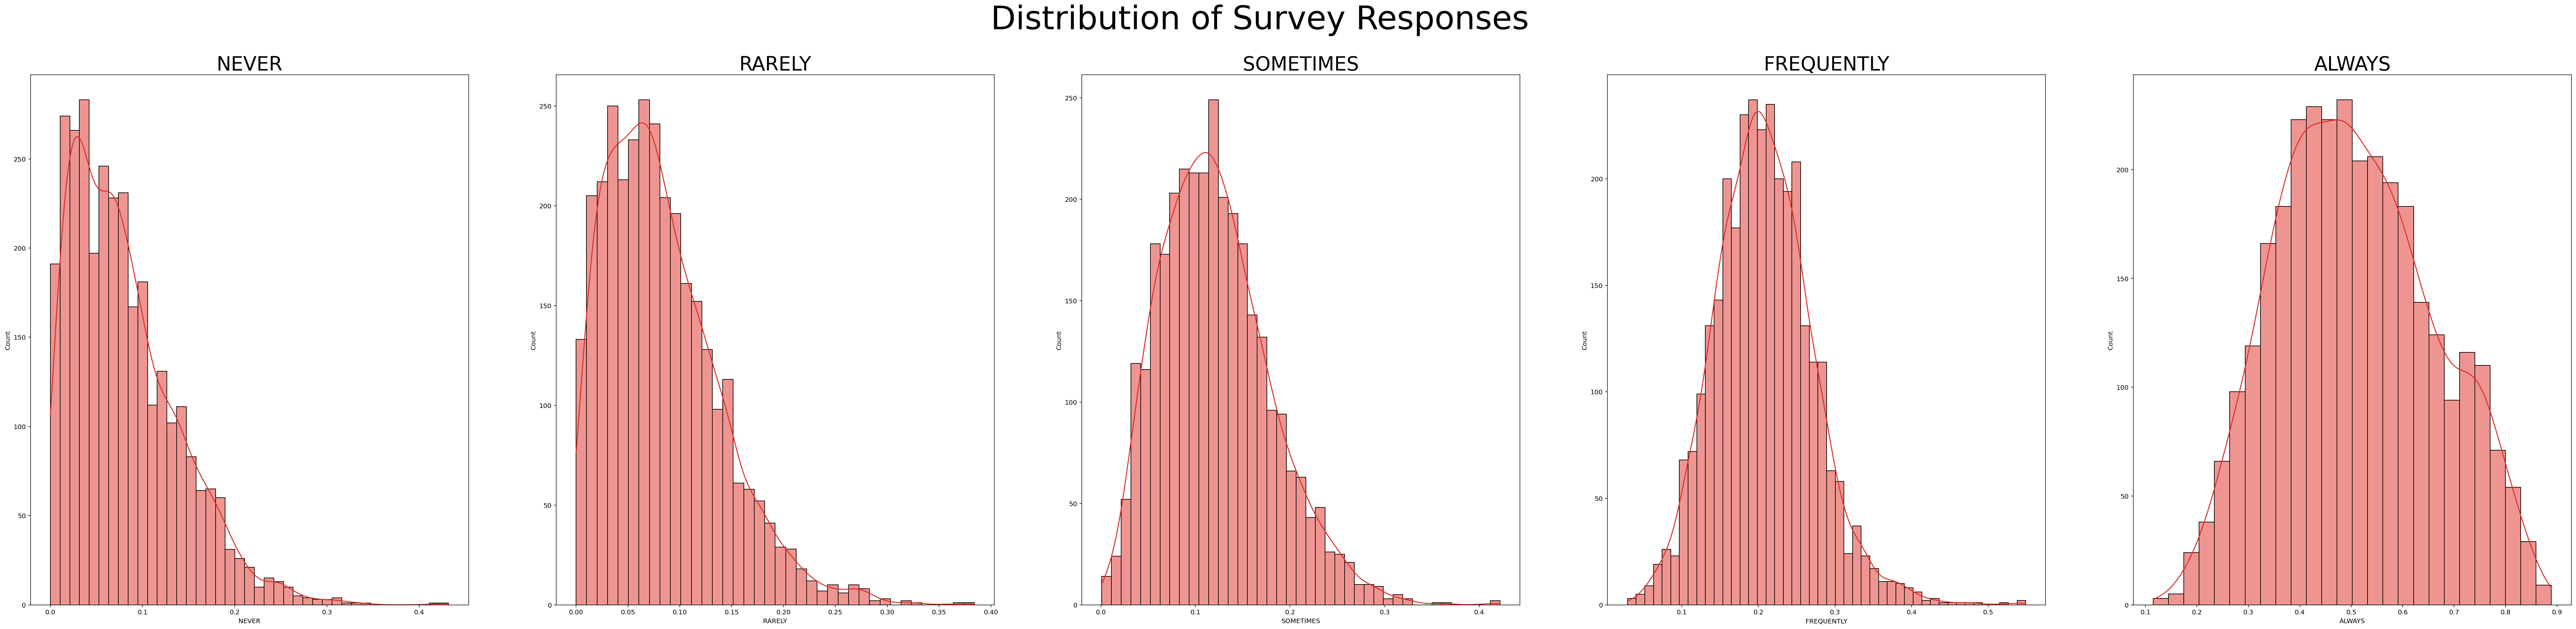

In [60]:
# plot to see the percentage distribution of responses looks likes for each state
plt.figure(figsize=(100,10))
fig, axes = plt.subplots(1, 5, figsize=(70,15))
fig.suptitle('Distribution of Survey Responses', fontsize=50)

sns.histplot(df_mask['NEVER'], kde=True, color='#DE2D26', ax=axes[0])
sns.histplot(df_mask['RARELY'], kde=True, color='#DE2D26', ax=axes[1])
sns.histplot(df_mask['SOMETIMES'], kde=True, color='#DE2D26', ax=axes[2])
sns.histplot(df_mask['FREQUENTLY'], kde=True, color='#DE2D26', ax=axes[3])
sns.histplot(df_mask['ALWAYS'], kde=True, color='#DE2D26', ax=axes[4])

axes[0].set_title('NEVER', fontsize=30)
axes[1].set_title('RARELY', fontsize=30)
axes[2].set_title('SOMETIMES', fontsize=30)
axes[3].set_title('FREQUENTLY', fontsize=30)
axes[4].set_title('ALWAYS', fontsize=30)

### Statistics

First, we will look at the averages of the survey results by state and by region to see any patterns that stick out to us immediately.

In [22]:
# find average of mask usage for each state
df_maskstates_avg = df_maskstates.groupby(['STATE','REGION_NAME'], as_index=False)[['NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS']].mean()

# sort the dataframe from highest to lowest ALWAYS responses 
df_maskstates_sorted = df_maskstates_avg.sort_values(by='ALWAYS', ascending=False)
df_maskstates_sorted

,STATE,REGION_NAME,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
7,DE,South,0.019333,0.006667,0.060667,0.095667,0.817667
10,HI,West,0.016200,0.018800,0.033400,0.116600,0.815000
38,RI,Northeast,0.012200,0.009600,0.040000,0.136000,0.802000
18,MA,Northeast,0.019500,0.011786,0.040143,0.131143,0.797286
6,CT,Northeast,0.017500,0.023000,0.053625,0.126375,0.779500
33,NY,Northeast,0.022839,0.022452,0.049387,0.135274,0.769935
30,NJ,Northeast,0.022905,0.021238,0.049429,0.157905,0.748429
19,MD,South,0.022917,0.020917,0.051542,0.161833,0.742750
4,CA,West,0.032310,0.030724,0.063690,0.158603,0.714638
37,PA,Northeast,0.035836,0.035388,0.086254,0.170657,0.671970


In [23]:
# look at the top 5 states that will ALWAYS wear a mask 
df_maskstates_avg.nlargest(5, ['ALWAYS'])

,STATE,REGION_NAME,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
7,DE,South,0.019333,0.006667,0.060667,0.095667,0.817667
10,HI,West,0.016200,0.018800,0.033400,0.116600,0.815000
38,RI,Northeast,0.012200,0.009600,0.040000,0.136000,0.802000
18,MA,Northeast,0.019500,0.011786,0.040143,0.131143,0.797286
6,CT,Northeast,0.017500,0.023000,0.053625,0.126375,0.779500


In [24]:
# look at the top 5 states that will NEVER wear a mask 
df_maskstates_avg.nlargest(5, ['NEVER'])

,STATE,REGION_NAME,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
27,ND,Midwest,0.180981,0.164019,0.145925,0.251811,0.257245
49,WY,West,0.151609,0.157000,0.123000,0.232000,0.336435
25,MT,West,0.150857,0.171589,0.144893,0.215143,0.317536
40,SD,Midwest,0.148318,0.105061,0.166682,0.219091,0.360939
23,MO,Midwest,0.134061,0.127165,0.151652,0.210539,0.376557


In [25]:
# find the average of mask usage for each region
df_maskregions_avg = df_maskstates.groupby('REGION_NAME', as_index=False)[['NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS']].mean()

# check dataframe for average mask usage by region 
df_maskregions_avg

,REGION_NAME,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,Midwest,0.105405,0.107358,0.144713,0.227495,0.415038
1,Northeast,0.030959,0.033889,0.066249,0.155240,0.713659
2,South,0.072164,0.072314,0.118904,0.199953,0.536652
3,West,0.068511,0.082906,0.100674,0.211339,0.536551


Interestingly, we see that the Northeast region is the most likely to always wear a mask when going out, followed by the South, West, and then the Midwest respectively. We can see the evidence for this as well, since the top 5 states with the highest average for always wearing a mask is primarily located in the Northeast region (DE, RI, MA, and CT). Maybe it has something to do with the fact that the region was hit the hardest at the beginning of the pandemic back in April 2020...?

### Data Vizualizations 

First, we want to look at the response proportions of these 5 highest and lowest mask-wearing states visually, rather than just the raw numbers in the statistics section. This will give us a general understanding of how these states' mask compliances compare to one another.

In [26]:
# create dataframe of just the 5 high/low states of mask usage
df_highlow_mask = df_maskstates[df_maskstates['STATE'].isin(['DE', 'HI', 'RI', 'MA', 'CT', 'ND', 'WY', 'MT','SD', 'MO'])]
df_highlow_mask = df_highlow_mask.groupby(['STATE','REGION_NAME'], as_index=False)[['NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS']].mean()

# sort from highest to lowest ALWAYS responses 
df_highlow_masksorted = df_highlow_mask.sort_values(by='ALWAYS', ascending=False)

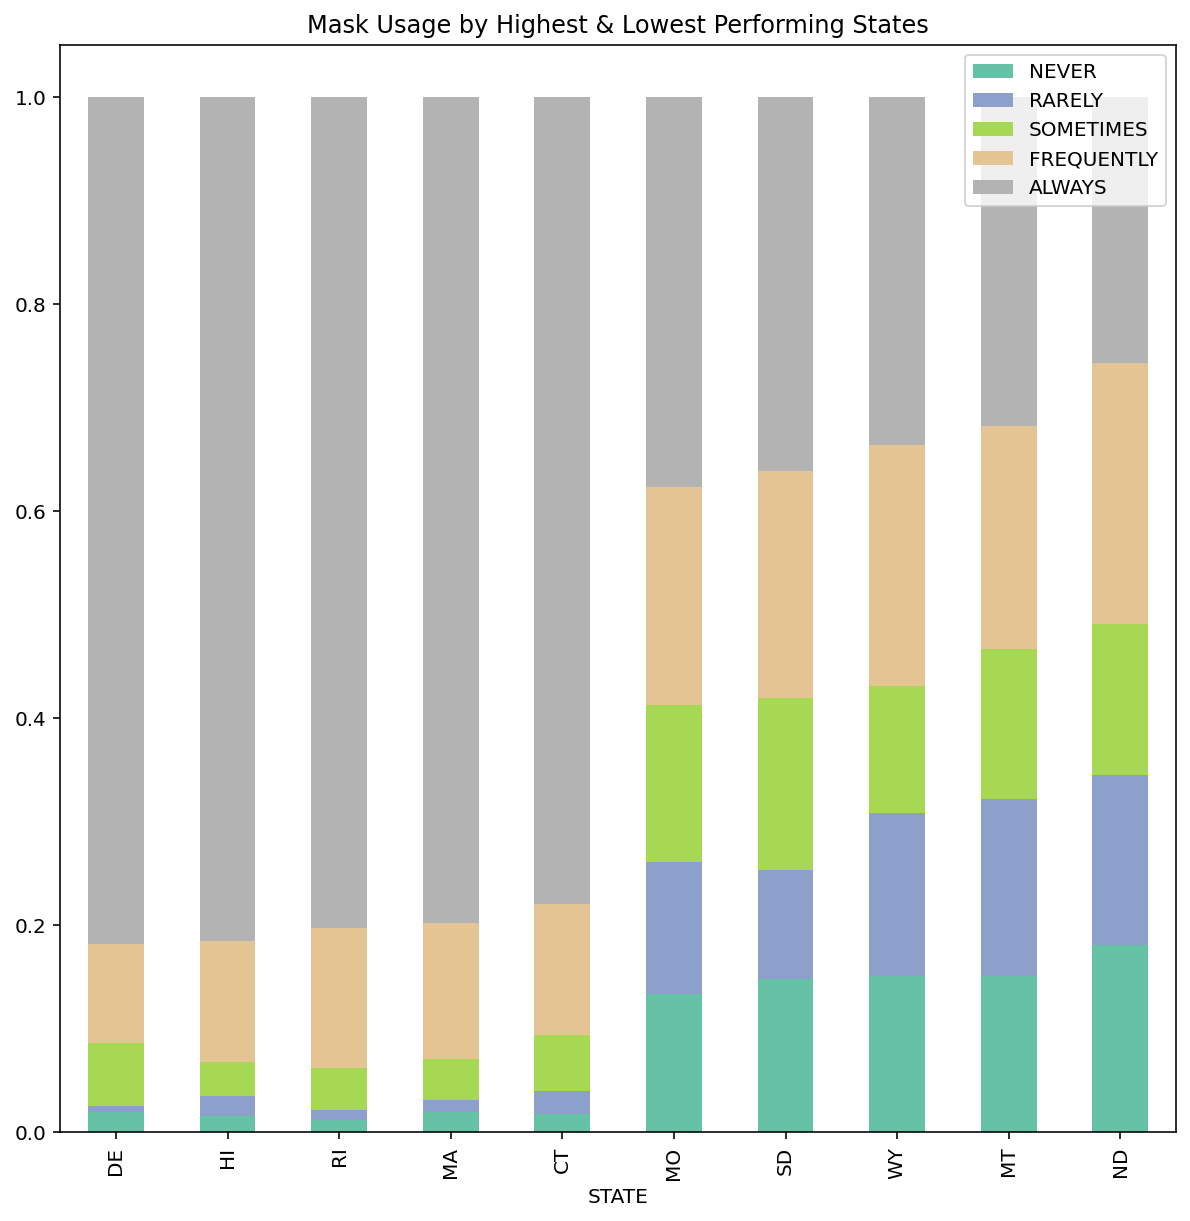

In [27]:
# plot to see how proportions of mask complicance looks like for each state
# reindex mask region dataframe 
df_highlow_masksorted.set_index('STATE', drop=True,inplace=True)
mask_plot = df_highlow_masksorted[['NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS']].plot(kind='bar', stacked=True, title='Mask Usage by Highest & Lowest Performing States', colormap='Set2', figsize=(10,10))
fig = mask_plot.get_figure()

Looking at this graph, we can see there's a significant difference in the usage of masks. The low mask-wearing states responses to `ALWAYS` is nearly 40% less than the high states! We should also look at the proportions by region. 

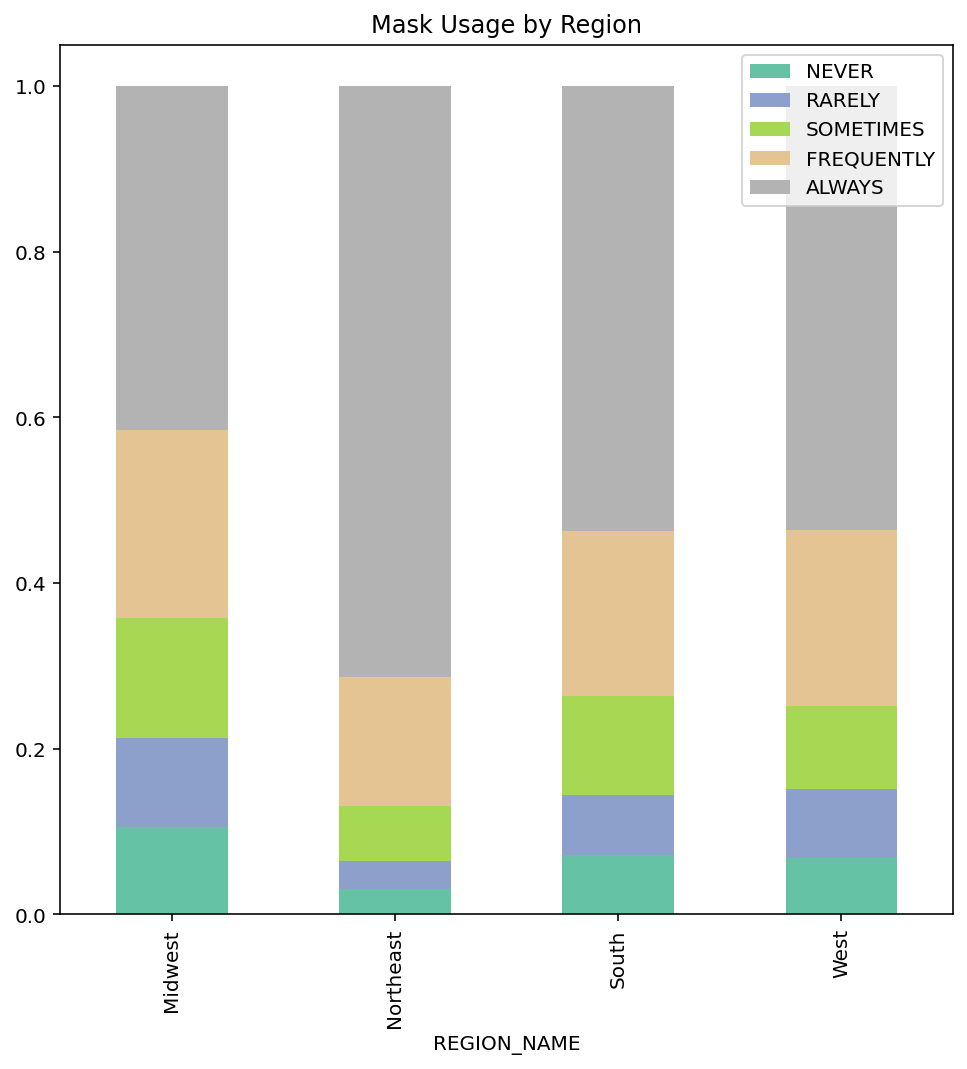

In [28]:
# plot to see how proportions of mask complicance looks like for each region
# reindex mask region dataframe 
df_maskregions_avg.set_index('REGION_NAME', drop=True,inplace=True)
avg_maskregions_plot = df_maskregions_avg[['NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS']].plot(kind='bar', stacked=True, title='Mask Usage by Region', colormap='Set2', figsize=(8,8))
fig = avg_maskregions_plot.get_figure()

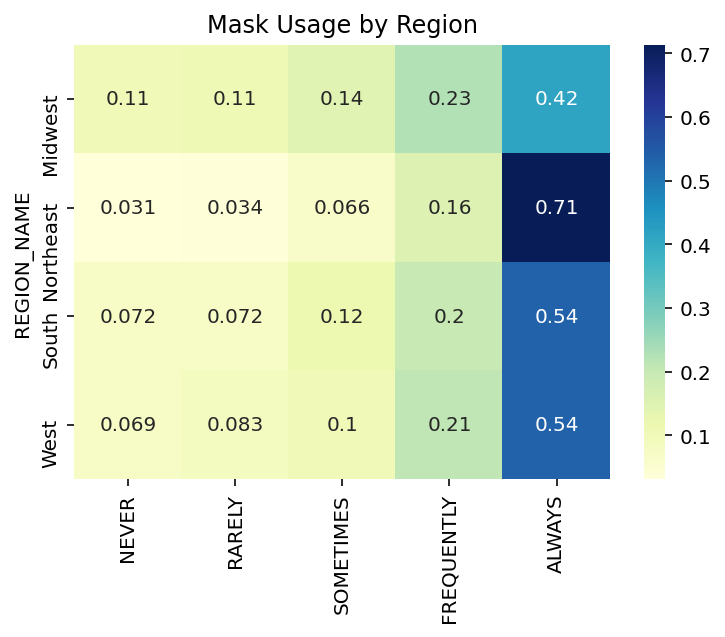

In [29]:
# create heatmap of the survey responses by region 
ax = sns.heatmap(df_maskregions_avg, cmap="YlGnBu", annot=True).set_title('Mask Usage by Region')

Looking at these plots, we can see that there's not a ***significant*** difference in the averages between the South and the West. Interestingly, Hawaii and California were both one of the top 10 states with the highest `ALWAYS` responses, placing #2 and #9 respectfully. But by region, the South has the greater average of `ALWAYS` responses compared to the West (numbers listed in the statistics section). 

This most likely implies that there are other states in the West that are lowering it's average. Knowing this, we also must consider that the US Census Bureau only considers there to be 4 regions to the United States. There are many other states besides California, Oregon, Washington, Nevada, etc. that are a part of the West, including North and South Dakota, Utah, Wyoming, Montana, and more. This consideration also applies to the South. Generally, people would consider Delaware and Maryland (both also part of the top 10 leaderboard) to be in the Northeast, however they're actually categorized as the South. 

## 3b) Vaccine EDA

### Distribution and Relationships

From the plots below, we see that most of the data takes a Gaussian distribution and that there doesn't seem to be any wild outliers.

Text(0.5, 1.0, 'PEOPLE FULLY VACCINATED')

<Figure size 7200x720 with 0 Axes>

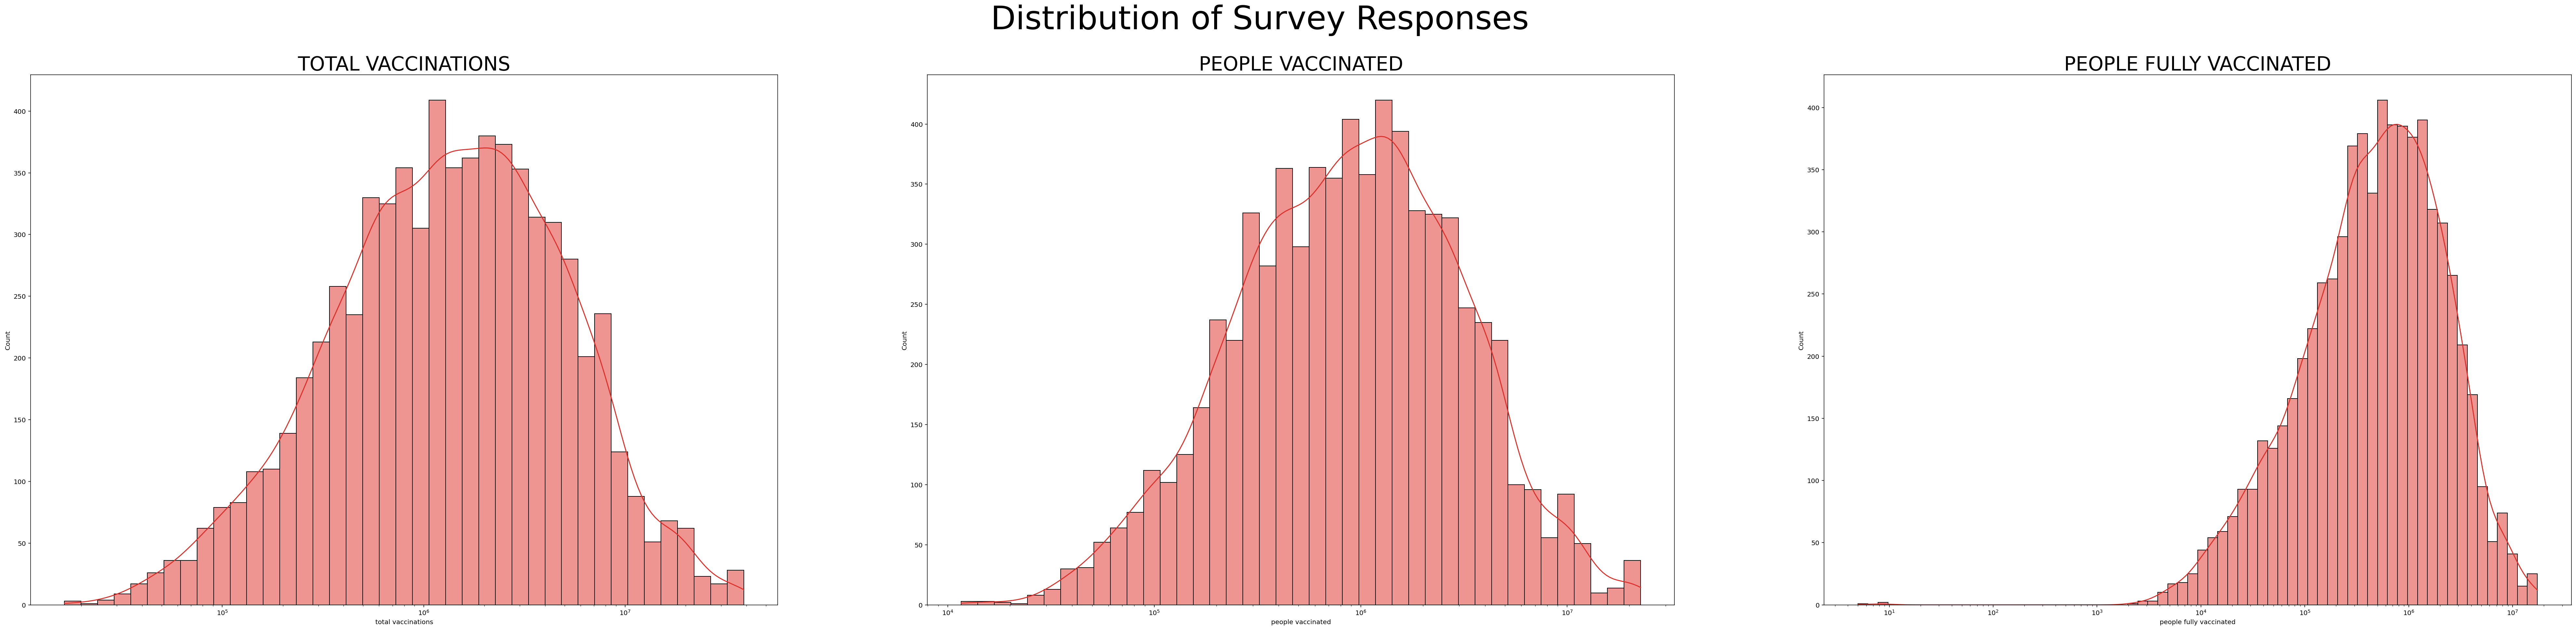

In [61]:
# plot to see the percentage distribution of responses looks likes for each state
plt.figure(figsize=(100,10))
fig, axes = plt.subplots(1, 3, figsize=(70,15))
fig.suptitle('Distribution of Survey Responses', fontsize=50)

# plot distribution of total vaccinations
sns.histplot(df_vaccine['total vaccinations'], kde=True,log_scale=True, color='#DE2D26', ax=axes[0])

# plot distribution of # of people vaccinated
sns.histplot(df_vaccine['people vaccinated'], kde=True,log_scale=True, color='#DE2D26', ax=axes[1])

# plot distribution of # of people fully vaccinated
sns.histplot(df_vaccine['people fully vaccinated'], kde=True,log_scale=True, color='#DE2D26', ax=axes[2])

axes[0].set_title('TOTAL VACCINATIONS', fontsize=30)
axes[1].set_title('PEOPLE VACCINATED', fontsize=30)
axes[2].set_title('PEOPLE FULLY VACCINATED', fontsize=30)

### Looking at the Most Recent Numbers

This dataset is updated daily with vaccination data from each state. Before exploring any patterns we see over time, we first want to look at the most recent update to get a general sense of what the current vaccination status is like  for each state.

In [31]:
# create a new dataframe that has information about the most recent observation 
# most recent date (at this moment) is 6/2/21
df_vaccine_recent = df_vaccine[df_vaccine['date'] == '2021-06-02T00:00:00.000000000']

In [32]:
# check the top 5 states with the HIGHEST # of people vaccinated (first AND second dose) per hundred
df_vaccine_recent.nlargest(5, ['people vaccinated per hundred'])

,date,STATE,total distributed,distributed per hundred,total vaccinations,total vaccinations per hundred,people vaccinated,people vaccinated per hundred,people fully vaccinated,people fully vaccinated per hundred,daily vaccinations,daily vaccinations raw,daily vaccinations per million,share doses used
8372,2021-06-02,VT,898540.0,144.00,778794.0,124.81,441390.0,70.74,352977.0,56.57,3392.0,1502.0,5436.0,0.867
2445,2021-06-02,HI,1848100.0,130.53,1592196.0,112.45,946896.0,66.88,676500.0,47.78,3834.0,0.0,2708.0,0.862
4317,2021-06-02,MA,9351320.0,135.67,8081349.0,117.25,4594429.0,66.66,3718511.0,53.95,40871.0,14056.0,5930.0,0.864
3885,2021-06-02,ME,1791190.0,133.25,1493486.0,111.10,855095.0,63.61,738946.0,54.97,5623.0,12217.0,4183.0,0.834
1293,2021-06-02,CT,4564385.0,128.02,4048712.0,113.56,2263604.0,63.49,1915836.0,53.74,14745.0,4092.0,4136.0,0.887


In [33]:
# check the top 5 states with the HIGHEST # of people FULLY vaccinated per hundred
df_vaccine_recent.nlargest(5, ['people fully vaccinated per hundred'])

,date,STATE,total distributed,distributed per hundred,total vaccinations,total vaccinations per hundred,people vaccinated,people vaccinated per hundred,people fully vaccinated,people fully vaccinated per hundred,daily vaccinations,daily vaccinations raw,daily vaccinations per million,share doses used
8372,2021-06-02,VT,898540.0,144.00,778794.0,124.81,441390.0,70.74,352977.0,56.57,3392.0,1502.0,5436.0,0.867
3885,2021-06-02,ME,1791190.0,133.25,1493486.0,111.10,855095.0,63.61,738946.0,54.97,5623.0,12217.0,4183.0,0.834
4317,2021-06-02,MA,9351320.0,135.67,8081349.0,117.25,4594429.0,66.66,3718511.0,53.95,40871.0,14056.0,5930.0,0.864
1293,2021-06-02,CT,4564385.0,128.02,4048712.0,113.56,2263604.0,63.49,1915836.0,53.74,14745.0,4092.0,4136.0,0.887
7341,2021-06-02,RI,1465775.0,138.36,1166826.0,110.14,648078.0,61.18,549970.0,51.92,4632.0,3231.0,4372.0,0.796


From these two cells, we can see that a number of states show up on both cell outputs twice. States that have the highest number of people vaccinated AND people ***fully*** vaccinated include: Vermont, Massachusetts, Connecticut, and Maine.

Hawaii is also included in the list of states with the highest number of people vaccinated, but Rhode Island surpasses it for the highest number of people ***fully*** vaccinated. Interestingly, most of these states also showed up in the top 5 states that will ***always*** wear a mask (HI, CT, MA, RI). Let's look at the states with the least number of people vaccinated and see if a trend exists there as well.

In [34]:
# check the top 5 states with the LOWEST # of people vaccinated (first AND second dose) per hundred
df_vaccine_recent.nsmallest(5, ['people vaccinated per hundred'])

,date,STATE,total distributed,distributed per hundred,total vaccinations,total vaccinations per hundred,people vaccinated,people vaccinated per hundred,people fully vaccinated,people fully vaccinated per hundred,daily vaccinations,daily vaccinations raw,daily vaccinations per million,share doses used
4749,2021-06-02,MS,2596955.0,87.26,1786563.0,60.03,1019870.0,34.27,815643.0,27.41,4299.0,17036.0,1444.0,0.688
3741,2021-06-02,LA,3903910.0,83.98,3095398.0,66.58,1668440.0,35.89,1457418.0,31.35,8467.0,4058.0,1821.0,0.793
141,2021-06-02,AL,4583270.0,93.48,3025283.0,61.70,1768055.0,36.06,1435324.0,29.27,3239.0,3007.0,661.0,0.660
9380,2021-06-02,WY,506735.0,87.56,397488.0,68.68,215413.0,37.22,185031.0,31.97,947.0,1852.0,1636.0,0.784
2589,2021-06-02,ID,1611435.0,90.17,1240621.0,69.42,673870.0,37.71,587228.0,32.86,2954.0,846.0,1653.0,0.770


In [35]:
# check the top 5 states with the LOWEST # of people FULLY vaccinated per hundred
df_vaccine_recent.nsmallest(5, ['people fully vaccinated per hundred'])

,date,STATE,total distributed,distributed per hundred,total vaccinations,total vaccinations per hundred,people vaccinated,people vaccinated per hundred,people fully vaccinated,people fully vaccinated per hundred,daily vaccinations,daily vaccinations raw,daily vaccinations per million,share doses used
4749,2021-06-02,MS,2596955.0,87.26,1786563.0,60.03,1019870.0,34.27,815643.0,27.41,4299.0,17036.0,1444.0,0.688
141,2021-06-02,AL,4583270.0,93.48,3025283.0,61.70,1768055.0,36.06,1435324.0,29.27,3239.0,3007.0,661.0,0.660
717,2021-06-02,AR,2772880.0,91.88,2083064.0,69.03,1196107.0,39.64,943122.0,31.25,5888.0,1797.0,1951.0,0.751
3741,2021-06-02,LA,3903910.0,83.98,3095398.0,66.58,1668440.0,35.89,1457418.0,31.35,8467.0,4058.0,1821.0,0.793
7773,2021-06-02,TN,6091270.0,89.19,4862445.0,71.20,2683878.0,39.30,2175414.0,31.85,12946.0,4222.0,1896.0,0.798


There are also similarities between the two cells. States that have the lowest number of people vaccinated AND people ***fully*** vaccinated include: Mississippi, Louisiana, and Alabama.

Wyoming and Idaho are on the list for the states with the lowest number of people vaccinated, but it has more people fully vaccinated than Arkansas and Tennesse do. Unlike the highest states though, only Wyoming showed up on the top 5 states who would ***never*** wear a mask. 

This might suggest that although the citizens of these states don't beleive in the efficacy of the vaccine or hesitant to get vaccinated, they will wear their masks more often than other states. 

In [36]:
# check the top 5 states with the highest # vaccines administered
df_vaccine_recent.nlargest(5, ['total vaccinations'])

,date,STATE,total distributed,distributed per hundred,total vaccinations,total vaccinations per hundred,people vaccinated,people vaccinated per hundred,people fully vaccinated,people fully vaccinated per hundred,daily vaccinations,daily vaccinations raw,daily vaccinations per million,share doses used
1005,2021-06-02,CA,47454630.0,120.10,38517344.0,97.48,22526275.0,57.01,17127972.0,43.35,148096.0,44615.0,3748.0,0.812
7917,2021-06-02,TX,30408955.0,104.87,23095348.0,79.65,12883519.0,44.43,10355208.0,35.71,87011.0,52924.0,3001.0,0.759
5901,2021-06-02,NY,22728725.0,116.84,19761096.0,101.58,10892343.0,55.99,9177409.0,47.18,89111.0,53718.0,4581.0,0.869
2013,2021-06-02,FL,23716135.0,110.42,18864968.0,87.83,10612421.0,49.41,8439014.0,39.29,73826.0,43671.0,3437.0,0.795
6909,2021-06-02,PA,15097495.0,117.93,12648220.0,98.80,7504071.0,58.62,5616507.0,43.87,51099.0,34007.0,3991.0,0.838


From this output looking at the total vaccinations, the leaderboard has changed from the past few that we've seen. States from all the different regions are listed here, more specifically: 1 from the West, 2 from the South, and 2 from the Northeast.

Although these states have the highest number of vaccinations, they have a big population and when looking at total vaccinations ***per hundred*** (below), we infer that there's still many people that still need to get vaccinated. 

In [37]:
# check the top 5 states with the highest # vaaccines administered
df_vaccine_recent.nlargest(5, ['total vaccinations per hundred'])

,date,STATE,total distributed,distributed per hundred,total vaccinations,total vaccinations per hundred,people vaccinated,people vaccinated per hundred,people fully vaccinated,people fully vaccinated per hundred,daily vaccinations,daily vaccinations raw,daily vaccinations per million,share doses used
8372,2021-06-02,VT,898540.0,144.00,778794.0,124.81,441390.0,70.74,352977.0,56.57,3392.0,1502.0,5436.0,0.867
4317,2021-06-02,MA,9351320.0,135.67,8081349.0,117.25,4594429.0,66.66,3718511.0,53.95,40871.0,14056.0,5930.0,0.864
1293,2021-06-02,CT,4564385.0,128.02,4048712.0,113.56,2263604.0,63.49,1915836.0,53.74,14745.0,4092.0,4136.0,0.887
2445,2021-06-02,HI,1848100.0,130.53,1592196.0,112.45,946896.0,66.88,676500.0,47.78,3834.0,0.0,2708.0,0.862
3885,2021-06-02,ME,1791190.0,133.25,1493486.0,111.10,855095.0,63.61,738946.0,54.97,5623.0,12217.0,4183.0,0.834


Looking at these 10 states with the highest and lowest vaccination progress, we can also examine the trends of the number of vaccines distributed over time. 

**For the 5 highest states we'll look at:** Vermont, Massachusetts, Connecticut, Maine, and Rhode Island (since they have ***more*** people fully vaccinated than Hawaii does)<br>
**For the 5 lowest states we'll look at:** Mississippi, Alabama, Louisiana, Arkansas, and Tennesee (since they have ***less*** people fully vaccinated than Wyoming and Idaho do)

In [38]:
# make a new dataframe of those states above only
df_high_vaccine = df_vaccine[df_vaccine['STATE'].isin(['VT', 'MA', 'CT', 'ME', 'RI'])]
df_low_vaccine = df_vaccine[df_vaccine['STATE'].isin(['MI', 'AL', 'LA', 'AK', 'TN'])]

<AxesSubplot:xlabel='date', ylabel='daily vaccinations'>

<Figure size 3600x1080 with 0 Axes>

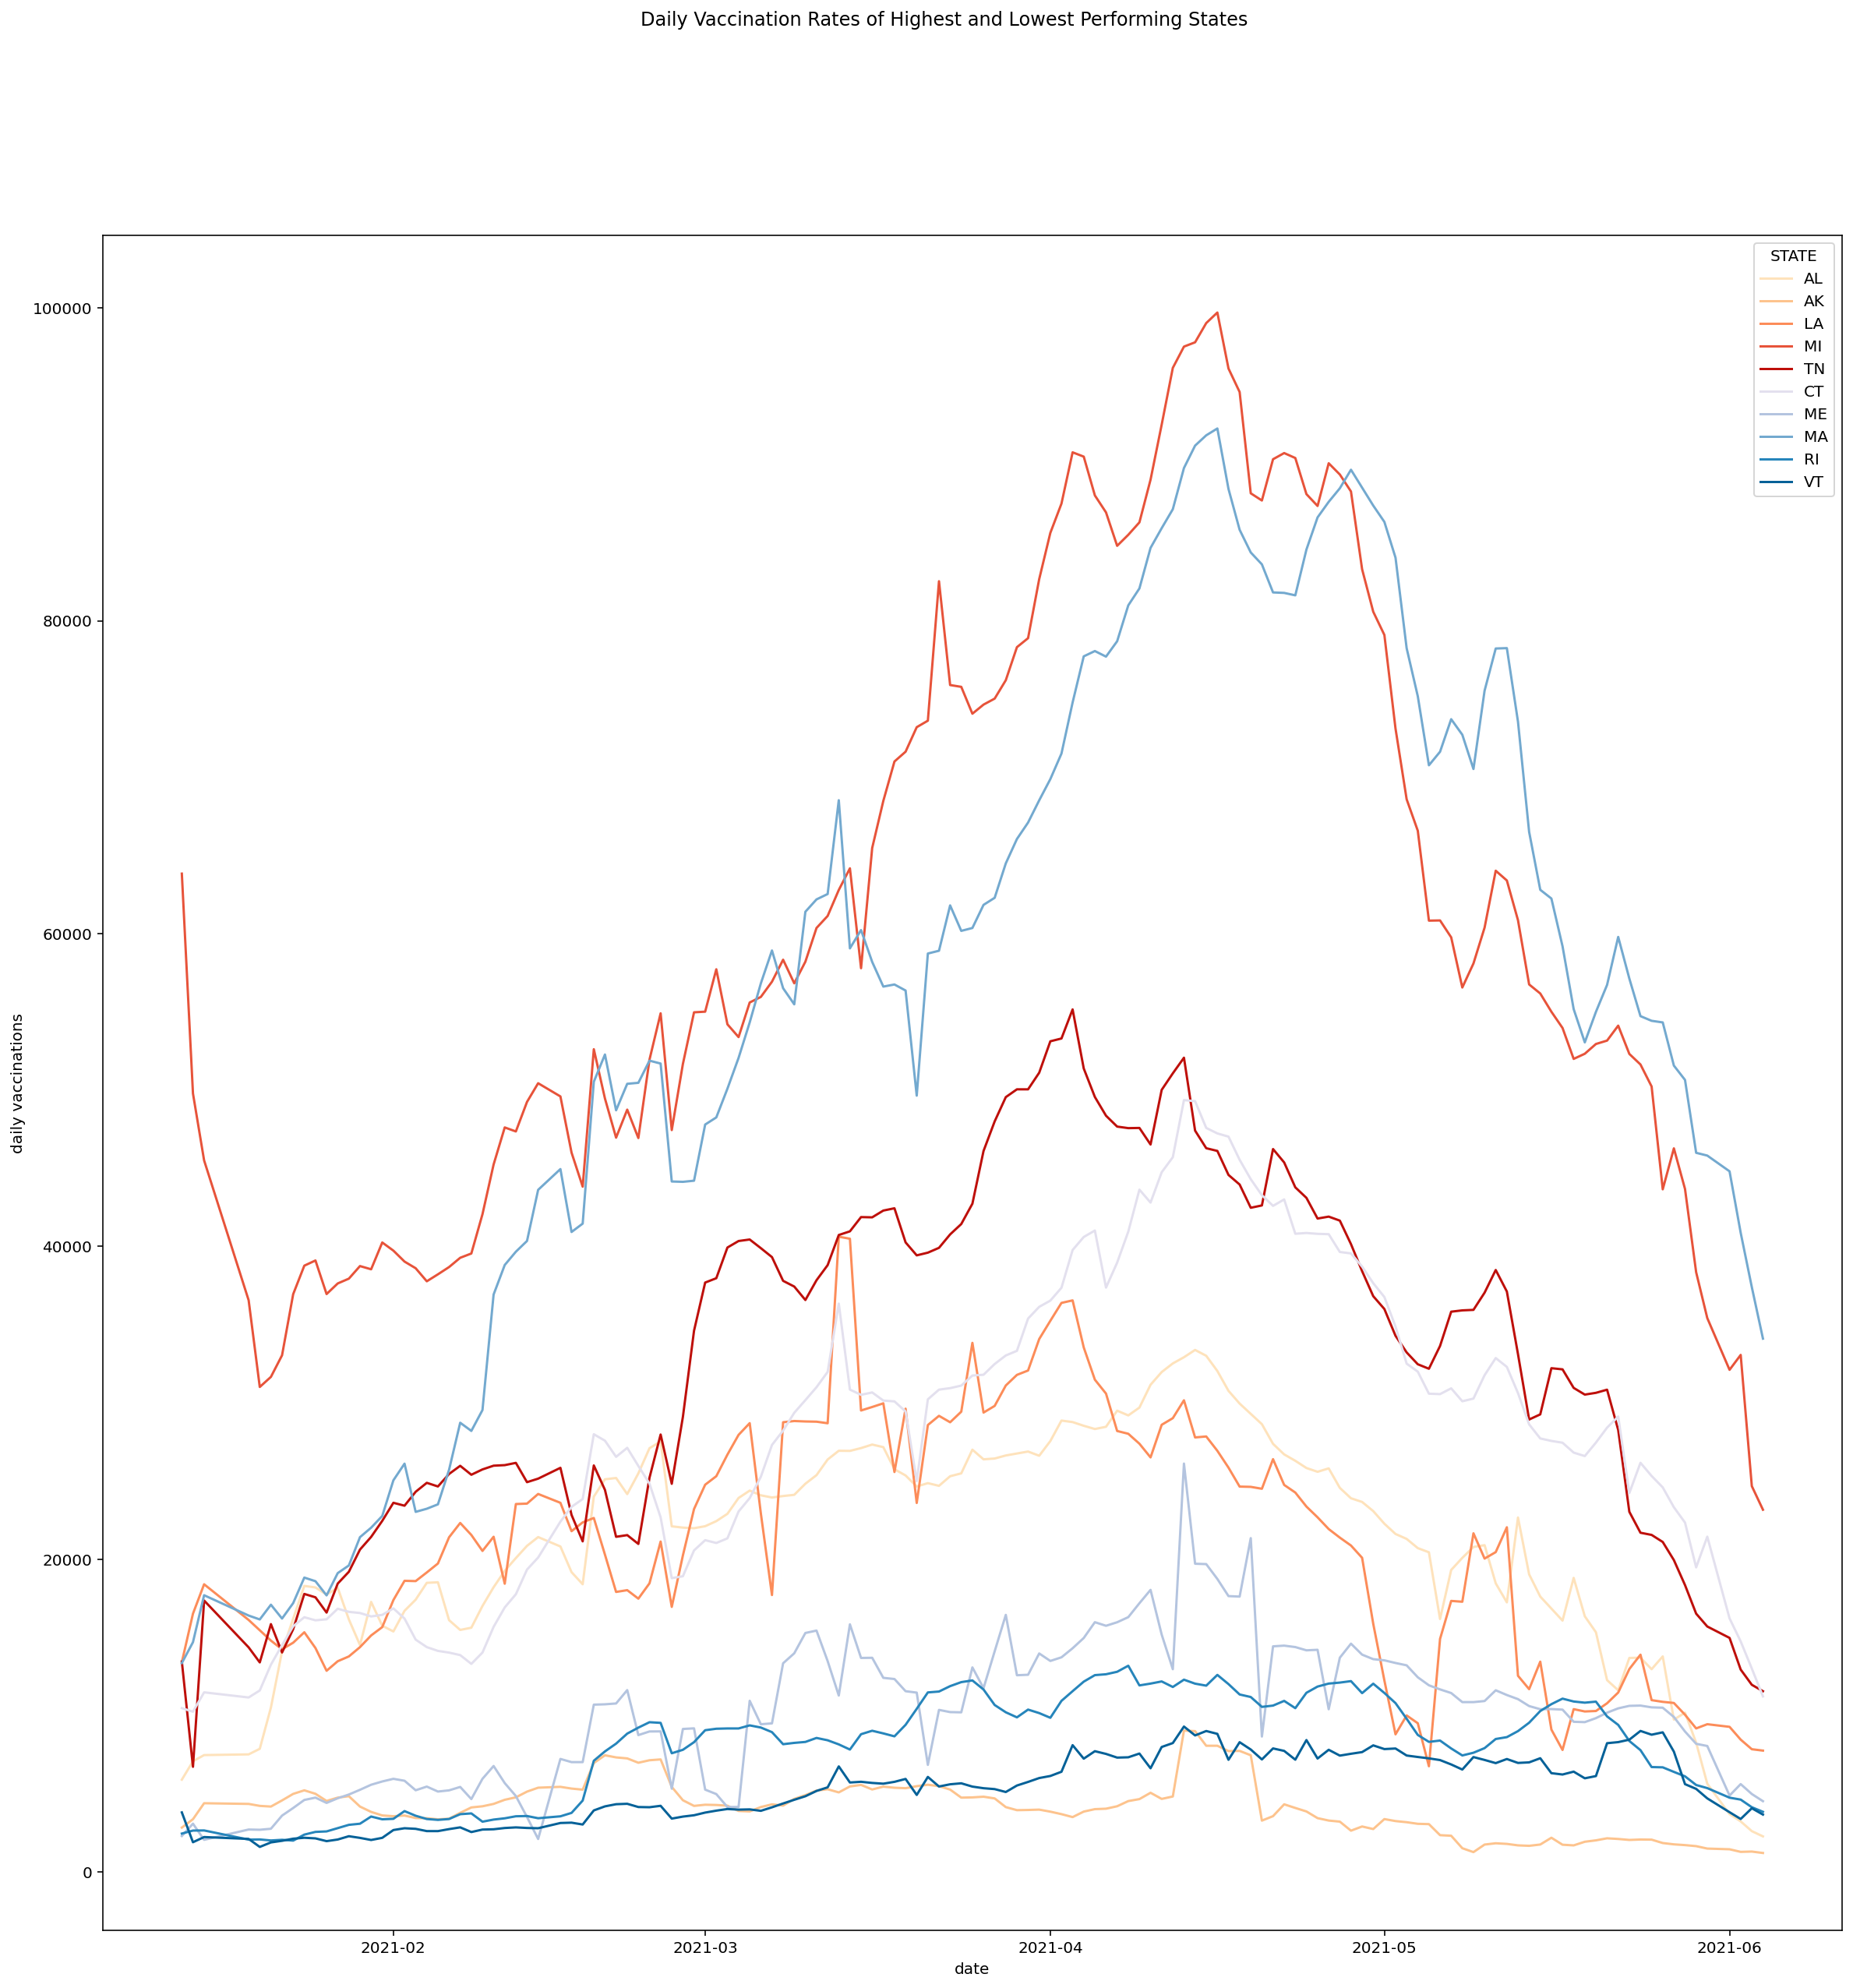

In [64]:
# set up figure
plt.figure(figsize=(50,15))
fig, axes = plt.subplots(1, 1, figsize=(20,20))
fig.suptitle('Daily Vaccination Rates of Highest and Lowest Performing States')

# plot set color for low states --> oranges
color_palette = sns.color_palette("OrRd", 5)
sns.set_palette(color_palette)
sns.lineplot(x='date', y='daily vaccinations', hue='STATE', data=df_low_vaccine)

# plot and set color for high states --> blues
color_palette = sns.color_palette("PuBu", 5)
sns.set_palette(color_palette)
sns.lineplot(x='date', y='daily vaccinations', hue='STATE', data=df_high_vaccine)

From this plot we can see that the states with the ***lowest*** (in warm colors) number of total vaccinations has a very staggering line plot of daily vaccinations. There are steep high rises, but also low drops; maybe suggesting there's something triggering a certain large group of people getting vaccinated in a period of time, but not reaching the entire state population. 

For the states with ***high*** vaccination rates (in cool colors), the daily number of vaccines distributed is fairly stable and constant compared to lower states, suggesting that maybe everyone is getting vaccinated everyday as doses become readily avilable, and slowly decreases around mid-April as the population becomes fully vaccinated.

### First and Second Doses

Something that we want to look into further is (1) information about the first dose only and (2) information about those who are fully vaccinated with two doses. We thought this would be interesting to look into this because 5 million people who got either Moderna or Pzifer (8%) are hesitant, or not at all, getting their second doses. Reasons for this vary, but some are scared of the infamous side effects of the second dose and others feel like they are protected with just the first dose. Another big reason is that vaccine providers have run out of supply or didn't have the right brand for patients to get their second dose within the 3-4 weeks after their first dose.

Reference: https://www.nytimes.com/2021/04/25/business/covid-vaccines-second-doses.html

In df_vaccine, the column `people vaccinated` includes people who have their first dose AND those who have their second dose. So, in order to get a dataframe that includes those who only have their first dose, we will have to subtract `people fully vaccinated` from `people vaccinated`.

In [40]:
# drop columns from df_vaccine that aren't relevant to either doses
df_both_dose = df_vaccine_recent.drop(['total vaccinations','total distributed','total vaccinations per hundred',
                                 'distributed per hundred','daily vaccinations raw','daily vaccinations',
                                 'daily vaccinations per million','share doses used'], axis = 1)

# subtract 'people fully vaccinated' from 'people vaccinated' 
# and 'people fully vaccinated per hundred' from 'people vaccinated per hundred' 
df_both_dose['people half vaccinated'] = df_both_dose['people vaccinated'] - df_both_dose['people fully vaccinated']
df_both_dose['people half vaccinated per hundred'] = df_both_dose['people vaccinated per hundred'] - df_both_dose['people fully vaccinated per hundred']

# final drop of columns not needed
df_both_dose = df_both_dose.drop(['people vaccinated','people vaccinated per hundred'], axis = 1)

df_both_dose.head()

,date,STATE,people fully vaccinated,people fully vaccinated per hundred,people half vaccinated,people half vaccinated per hundred
141,2021-06-02,AL,1435324.0,29.27,332731.0,6.79
285,2021-06-02,AK,288123.0,39.39,50106.0,6.84
573,2021-06-02,AZ,2631433.0,36.15,749409.0,10.30
717,2021-06-02,AR,943122.0,31.25,252985.0,8.39
1005,2021-06-02,CA,17127972.0,43.35,5398303.0,13.66


Make a dataframe with just information on the first dose for later analysis.

In [41]:
# drop columns that aren't about the first dose
df_first_dose = df_both_dose.drop(['people fully vaccinated','people fully vaccinated per hundred'], axis = 1)

df_first_dose.head()

,date,STATE,people half vaccinated,people half vaccinated per hundred
141,2021-06-02,AL,332731.0,6.79
285,2021-06-02,AK,50106.0,6.84
573,2021-06-02,AZ,749409.0,10.30
717,2021-06-02,AR,252985.0,8.39
1005,2021-06-02,CA,5398303.0,13.66


Lastly, make a dataframe with just data about the second dose.

In [42]:
# creating dataframe containing information about the second dose only
# drop columns from df_vaccine that aren't relevant to fully vaccinated people/the second dose
df_second_dose = df_vaccine_recent.drop(['total vaccinations','total distributed','people vaccinated',
                                  'total vaccinations per hundred','people vaccinated per hundred',
                                  'distributed per hundred','daily vaccinations raw','daily vaccinations',
                                  'daily vaccinations per million','share doses used'], axis = 1)

df_second_dose.head()

,date,STATE,people fully vaccinated,people fully vaccinated per hundred
141,2021-06-02,AL,1435324.0,29.27
285,2021-06-02,AK,288123.0,39.39
573,2021-06-02,AZ,2631433.0,36.15
717,2021-06-02,AR,943122.0,31.25
1005,2021-06-02,CA,17127972.0,43.35


Text(0.5, 1.0, 'First vs. Second Dose Vaccinations Per Hundred')

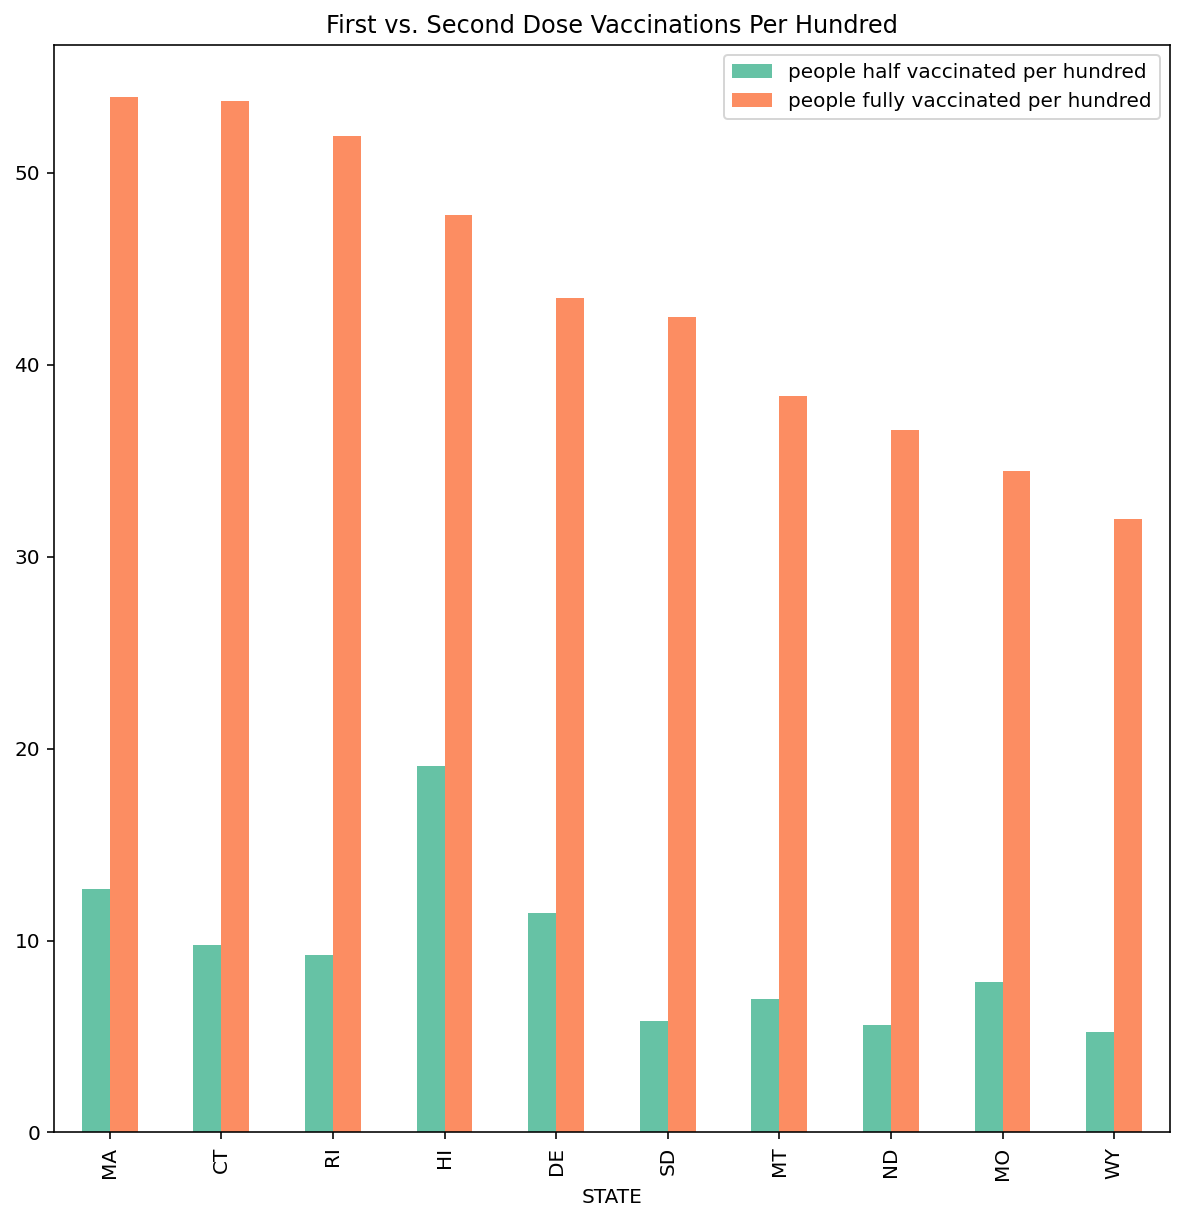

In [43]:
# look at just the high/low performing states 
df_highlow_both = df_both_dose[df_both_dose['STATE'].isin(['DE', 'HI', 'RI', 'MA', 'CT', 'ND', 'WY', 'MT','SD', 'MO'])]

# reorder columns so it's high states first, then low 
df_highlow_bothsorted = df_highlow_both.sort_values(by='people fully vaccinated per hundred', ascending=False)

# plot double bar graph to show 
color_palette = sns.color_palette('Set2', 2)
sns.set_palette(color_palette)
df_highlow_bothsorted.plot(x="STATE", y=["people half vaccinated per hundred", "people fully vaccinated per hundred"], kind="bar", figsize=(10,10)).set_title('First vs. Second Dose Vaccinations Per Hundred')

Looking at this plot comparing the number of fully vaccinated people and those that are half vaccinated, we can see that there are many more people that are fully vaccinated than those that aren't (currently). We can assume that although some people aren't getting their second dose like the article states, those cases don't have a major effect of the overall state's progress of fully vaccinating their citizens, but we would have to do some tests to make sure.

## 3c) Comparing Mask Compliance to Full Vaccinations 

Our assumption is that there will be a relationship between the proportion of full vaccinations and the proportion of mask compliance in each of the states. Specifically, we want to compare the `ALWAYS` column in the mask compliance dataset to the number of full vaccinations divided by each state's populatoion. To do this, we imported a dataset containing historical state populations by year. We will only use state populations collected in 2019 because it is the most recent observation.

In [44]:
# create dataframe of state populations
df_state_pops = pd.read_csv('https://raw.githubusercontent.com/JoshData/historical-state-population-csv/primary/historical_state_population_by_year.csv', names = ['location','year','population'])

# we only need 2019 data
df_state_pops = df_state_pops[df_state_pops['year'] == 2019]
df_state_pops = df_state_pops.rename(columns = {'location': 'STATE'})

df_state_pops.head()

,STATE,year,population
69,AK,2019,731545
189,AL,2019,4903185
309,AR,2019,3017804
429,AZ,2019,7278717
549,CA,2019,39512223


Next, we need to append this data to the original df_vaccine dataset to calculate the proportion of full vaccinations over population for each state. 

In [45]:
# merge datasets
df_vaccine = pd.merge(left = df_vaccine, right = df_state_pops, on = 'STATE')

# adding a new column to get the proportions 
df_vaccine['full vaccinations proportion'] = df_vaccine['people fully vaccinated']/df_vaccine['population']
df_vaccine.head()

,date,STATE,total distributed,distributed per hundred,total vaccinations,total vaccinations per hundred,people vaccinated,people vaccinated per hundred,people fully vaccinated,people fully vaccinated per hundred,daily vaccinations,daily vaccinations raw,daily vaccinations per million,share doses used,year,population,full vaccinations proportion
0,2021-01-12,AL,377025.0,7.69,78134.0,1.59,70861.0,1.45,7270.0,0.15,NaN,NaN,NaN,0.207,2019,4903185,0.001483
1,2021-01-13,AL,378975.0,7.73,84040.0,1.71,74792.0,1.53,9245.0,0.19,5906.0,5906.0,1205.0,0.222,2019,4903185,0.001886
2,2021-01-14,AL,435350.0,8.88,92300.0,1.88,80480.0,1.64,NaN,NaN,7083.0,8260.0,1445.0,0.212,2019,4903185,NaN
3,2021-01-15,AL,444650.0,9.07,100567.0,2.05,86956.0,1.77,13488.0,0.28,7478.0,8267.0,1525.0,0.226,2019,4903185,0.002751
4,2021-01-19,AL,444650.0,9.07,130795.0,2.67,114319.0,2.33,16346.0,0.33,7523.0,7557.0,1534.0,0.294,2019,4903185,0.003334


In [46]:
# find rows where date is max and sort values by proportion
(df_vaccine[df_vaccine['date'] == df_vaccine['date'].max()][['date','STATE','full vaccinations proportion']].sort_values(by = 'full vaccinations proportion', ascending = False).head())

,date,STATE,full vaccinations proportion
6254,2021-06-04,VT,0.571544
2640,2021-06-04,ME,0.555101
2918,2021-06-04,MA,0.545981
972,2021-06-04,CT,0.541360
5420,2021-06-04,RI,0.523628


We can make use of Folium, a package that helps visualize data on an interactive leaflet map. Using the choropleth map, we will shade in states with a higher proportion of full vaccinations:

In [47]:
# datastructure to hold maps 
maplist = []

In [48]:
### GRAPH OF FULL VACCINATION PROPORTIONS

url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
state_geo = f"{url}/us-states.json"
m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name="Desnity Map of State Vaccination Progress",
    data= df_vaccine[df_vaccine.date == df_vaccine.date.max()][['STATE','full vaccinations proportion']],
    columns=['STATE','full vaccinations proportion'],
    
    key_on="feature.id",
    fill_color="BuPu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Vaccination Progress",
).add_to(m)

folium.LayerControl().add_to(m)

# append to the maplist 
maplist.append(m)

Now we can make the same density plot for the 'ALWAYS' column in the df_maskstates_avg dataset to see if there are similarities:

In [49]:
# reset index so that we have a column for states
df_maskstates_avg.reset_index(level=0, inplace=True)

df_maskstates_avg[['STATE', 'ALWAYS']].sort_values(by = 'ALWAYS', ascending = False).head()

,STATE,ALWAYS
7,DE,0.817667
10,HI,0.815000
38,RI,0.802000
18,MA,0.797286
6,CT,0.779500


In [50]:
### GRAPH OF MASK COMPLIANCE

url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
state_geo = f"{url}/us-states.json"
m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name="Desnity Map of Mask Compliance",
    data= df_maskstates_avg,
    columns=['STATE', 'ALWAYS'],
    
    key_on="feature.id",
    fill_color="BuPu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Mask Compliance",
).add_to(m)

folium.LayerControl().add_to(m)

#append to the maplist
maplist.append(m)

In [51]:
# display the maps 
print('VACCINATION PROGRESS')
display(maplist[0])

print('MASK COMPLIANCE')
display(maplist[1])

VACCINATION PROGRESS


MASK COMPLIANCE


**Picture of Vaccination Progress if map isn't rendering on Github:**
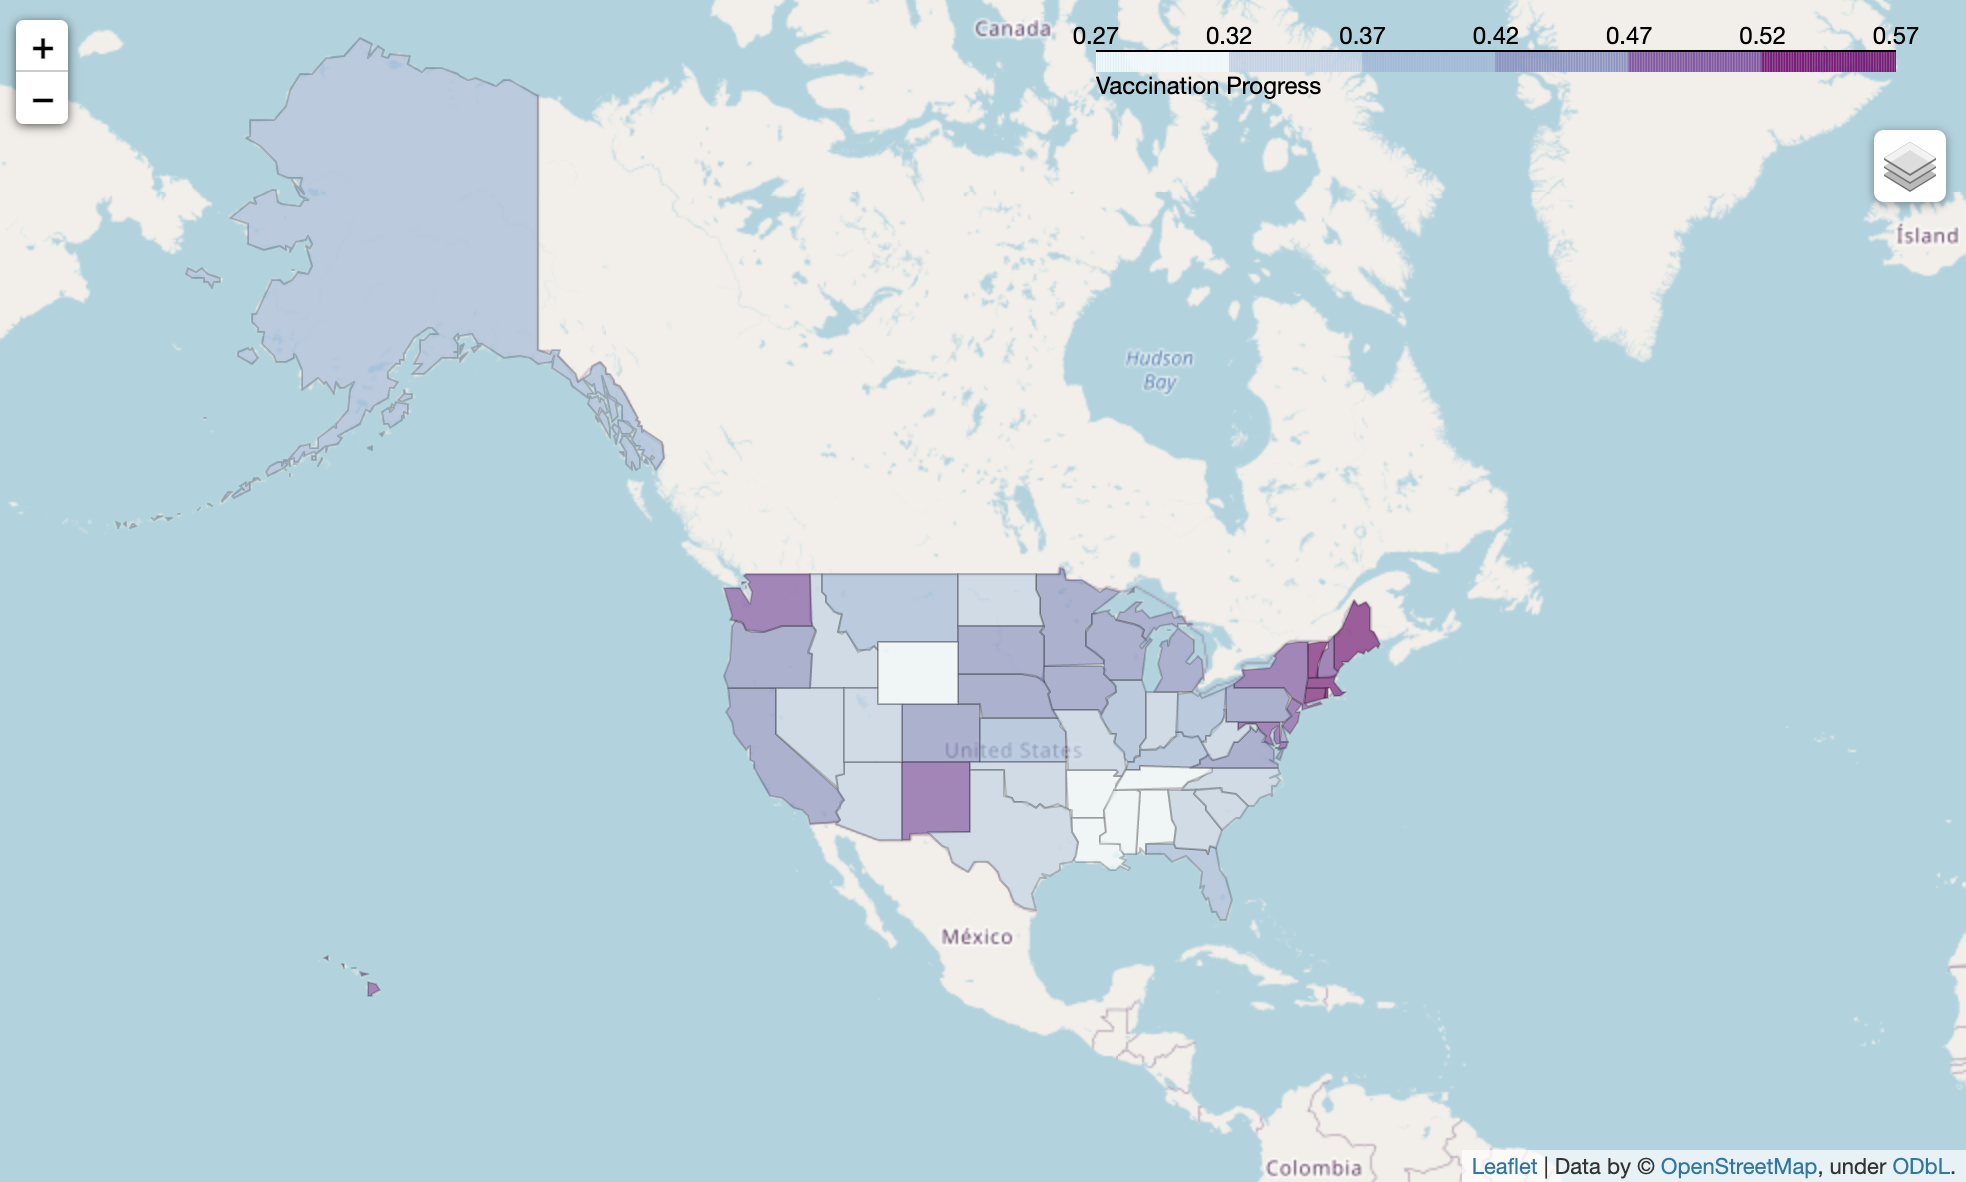

**Picture of Mask Compliance if map isn't rendering on Github:**
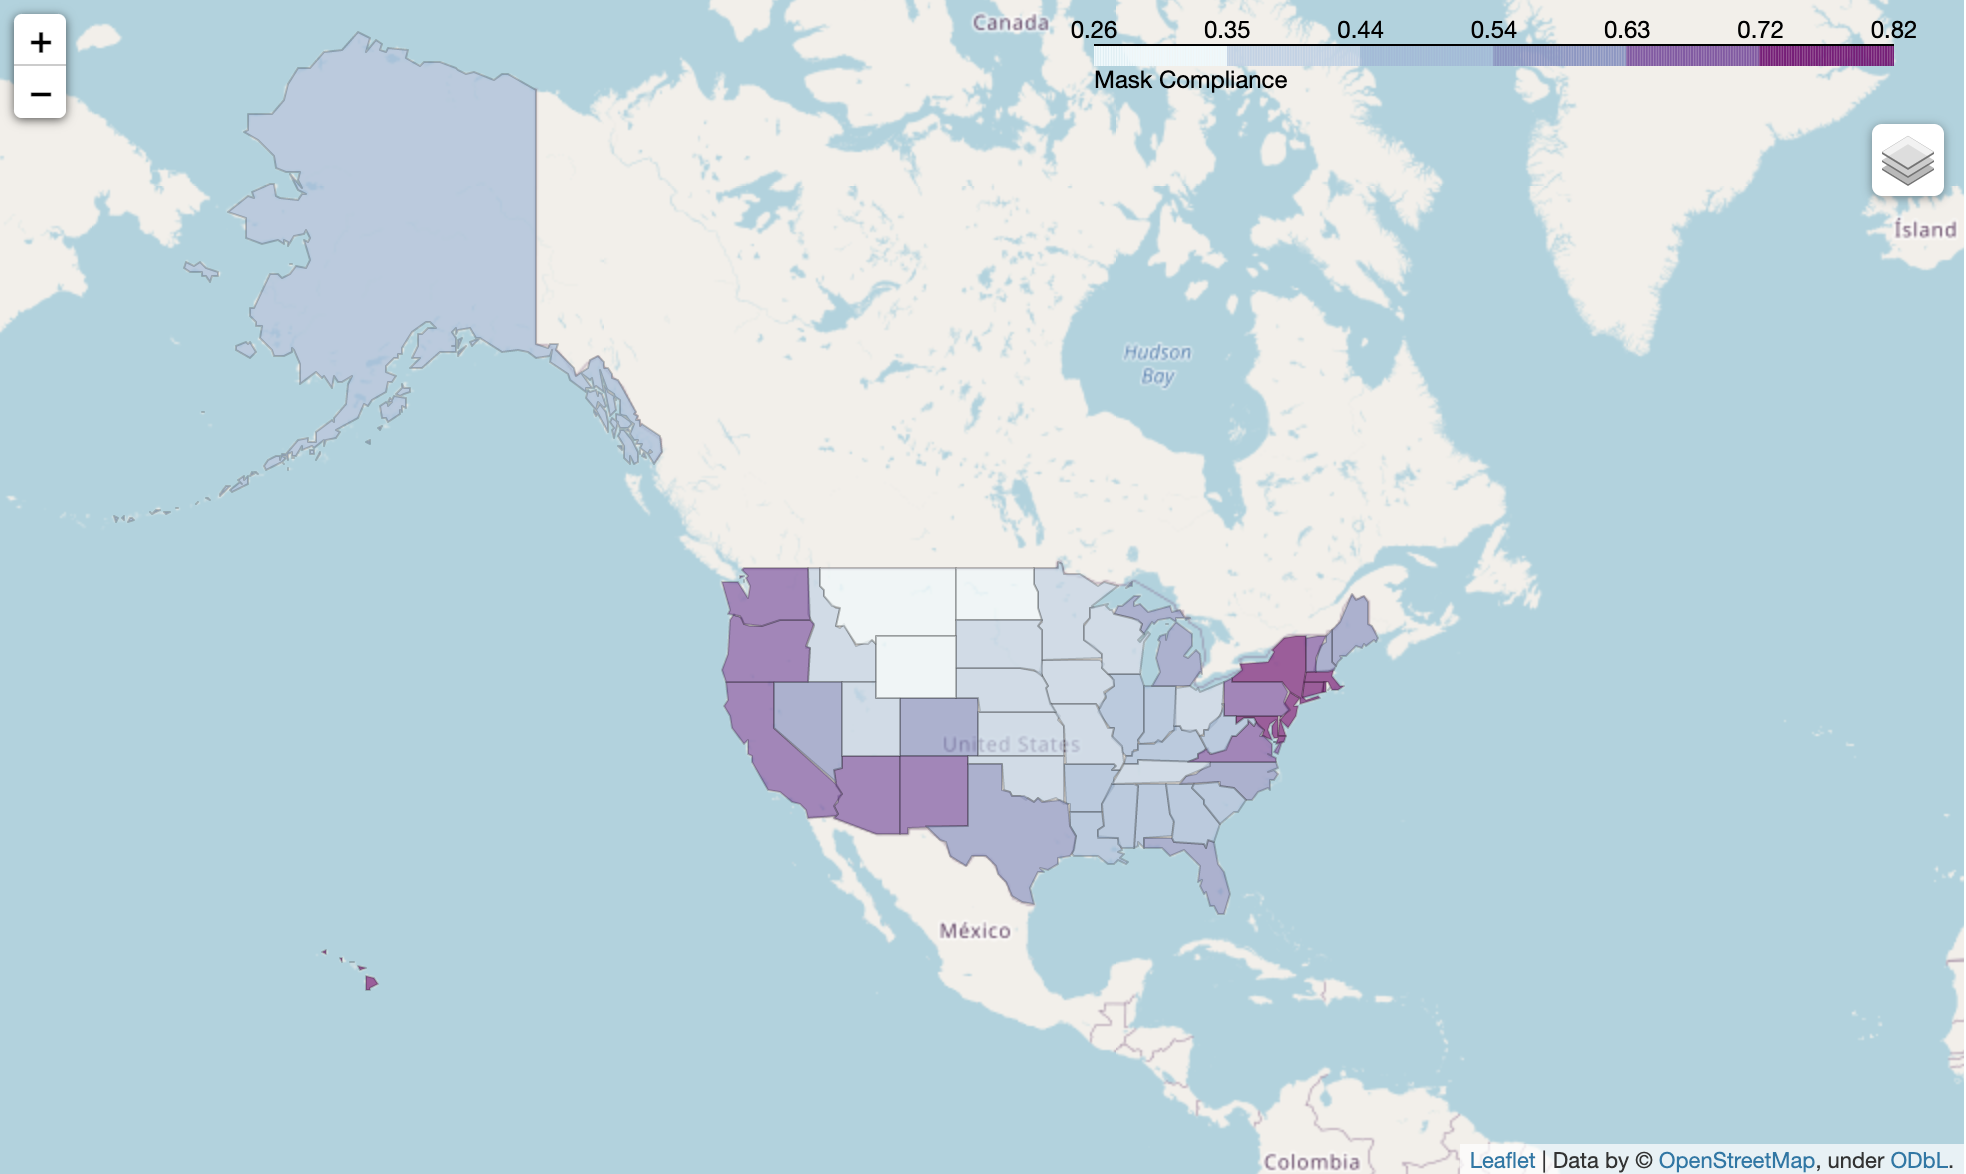

We can see that the maps do share similarities in shading, especially in states in the Northeast. It is interesting to note that in the mask compliance map, states on the West coast are shaded much darker than they are on the vaccination progress map. However, this could be attributed to the fact that these states have higher populations and so vaccination progress might be slower.

Of course, simply eyeballing the maps is not enough evidence to suggest that there are significant differences between state vaccination progress and state mask compliance. In the next section, we will carry out the appropriate testing procedures to test our hypothesis

## 3d) Inferential Analysis and Results

To see if our assumptions from our EDA are correct or not, we will carry out two regression tests. The first test will be looking at is mask compliance to fully vaccinated people. 

In [52]:
# carry out linear regression for mask and vaccine 
# merge the mask data with the second dose to see full vaccinations 
df_maskvaccine = pd.merge(df_maskstates_avg,df_second_dose, how='left', on=['STATE'])
df_maskvaccine.head()

,index,STATE,REGION_NAME,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,date,people fully vaccinated,people fully vaccinated per hundred
0,0,AK,West,0.055138,0.063172,0.089862,0.333103,0.458586,2021-06-02,288123.0,39.39
1,1,AL,South,0.081567,0.081090,0.146612,0.215343,0.475313,2021-06-02,1435324.0,29.27
2,2,AR,South,0.090920,0.087253,0.138360,0.220627,0.462867,2021-06-02,943122.0,31.25
3,3,AZ,West,0.049667,0.053200,0.094667,0.147333,0.655000,2021-06-02,2631433.0,36.15
4,4,CA,West,0.032310,0.030724,0.063690,0.158603,0.714638,2021-06-02,17127972.0,43.35


In [53]:
# carry and print out OLS regression results 
outcome_vacmask, predictors_vacmask = patsy.dmatrices('Q("people fully vaccinated per hundred") ~ ALWAYS + NEVER + SOMETIMES', df_maskvaccine)
mod_log_vacmask = sm.OLS(outcome_vacmask,predictors_vacmask)
res_log_vacmask = mod_log_vacmask.fit()
print(res_log_vacmask.summary())

                                       OLS Regression Results                                       
Dep. Variable:     Q("people fully vaccinated per hundred")   R-squared:                       0.399
Model:                                                  OLS   Adj. R-squared:                  0.359
Method:                                       Least Squares   F-statistic:                     10.16
Date:                                      Sat, 05 Jun 2021   Prob (F-statistic):           2.99e-05
Time:                                              01:21:22   Log-Likelihood:                -157.35
No. Observations:                                        50   AIC:                             322.7
Df Residuals:                                            46   BIC:                             330.3
Df Model:                                                 3                                         
Covariance Type:                                  nonrobust                                

**The p-values for `ALWAYS`, `NEVER`, and `SOMETIMES` were 0.963, 0.835, and 0.088 respectively. All p-values are greater than 0.05, indicating that there is not significant relationship between getting fully vaccinated and mask compliance.** This reveals that our inital hypothesis was incorrect: mask compliance doesn't always mean that those states are or aren't getting vaccinated. And we can see evidence for this by looking at the choropleth maps.

Some states (specifically Montana, South Dakota, and Nebraska) *are vaccinating* their citizens more than other states, yet the citizens *don't wear masks*. And in some states this scenario is flipped, where these states *will wear a mask*, but *don't* want to get vaccinated (specifically Louisanna, Georgia, Alabama, and other states in the deep South). The one main pattern we do see is that the Northeast states is doing *both*; they're wearing masks and getting their vaccines, which we noticed early on when looking at the top 5 highest performing states for both datasets. 

Based on these findings, we infer that people have different preferences (so to speak) on how to handle their safety during the pandemic. Some will prefer to just wear a mask and avoid the vaccine due to personal reasons or some will get the vaccine due to their personal dislikes of wearing masks. Whatever the scenario may be, we know now that mask compliance does not predict or mean that a population will get vaccinated.  

In [54]:
# carry out linear regression for first and second doses
df_vaccinedose = pd.merge(df_first_dose,df_second_dose, how='left', on=['STATE'])
df_vaccinedose.head()

,date_x,STATE,people half vaccinated,people half vaccinated per hundred,date_y,people fully vaccinated,people fully vaccinated per hundred
0,2021-06-02,AL,332731.0,6.79,2021-06-02,1435324.0,29.27
1,2021-06-02,AK,50106.0,6.84,2021-06-02,288123.0,39.39
2,2021-06-02,AZ,749409.0,10.30,2021-06-02,2631433.0,36.15
3,2021-06-02,AR,252985.0,8.39,2021-06-02,943122.0,31.25
4,2021-06-02,CA,5398303.0,13.66,2021-06-02,17127972.0,43.35


In [55]:
# carry and print out OLS regression results 
outcome_vacdose, predictors_vacdose = patsy.dmatrices('Q("people fully vaccinated per hundred") ~ Q("people half vaccinated per hundred")', df_vaccinedose)
mod_log_vacdose = sm.OLS(outcome_vacdose,predictors_vacdose)
res_log_vacdose = mod_log_vacdose.fit()
print(res_log_vacdose.summary())

                                       OLS Regression Results                                       
Dep. Variable:     Q("people fully vaccinated per hundred")   R-squared:                       0.226
Model:                                                  OLS   Adj. R-squared:                  0.210
Method:                                       Least Squares   F-statistic:                     14.02
Date:                                      Sat, 05 Jun 2021   Prob (F-statistic):           0.000484
Time:                                              01:21:22   Log-Likelihood:                -163.65
No. Observations:                                        50   AIC:                             331.3
Df Residuals:                                            48   BIC:                             335.1
Df Model:                                                 1                                         
Covariance Type:                                  nonrobust                                

**The p-value is 0.0005, thus we reject the null and can say that there is a significant relationship between people getting their first dose and people getting their second dose of the COVID vaccine.** At first, we thought that there may be less fully vaccinated people due to personal fears of getting their second dose, or whatever reason they may have. But our EDA visualization and regression test shows that this isn't the case. There is a signifcant relationshp and the plot shows that there are *many* more people that are fully vaccinated than those that just have one dose, so our assumption was also incorrect. 

We also have to keep in mind that the dataset does not account for the 3-4 week waiting period between doses, so this data is still being updated. Perhaps looking at the data again in the future when daily vaccinations come to an end, we would be able to get the final picture of those who are only half vs. fully vaccinated.

# IV. Ethics and Privacy

In terms of data ethics and privacy, we must consider what the implications for our project are, especially considering a sensitive topic such as COVID. The pandemic has been a tumultuous time that has negatively impacted many individuals. We must remain empathetic and compassionate in the way we choose to present the data and its results. Furthermore, it is important to consider that COVID, both in terms of mask wearing and vaccinations, became a very politicized issue, with political parties taking varying stances on the pandemic. This has created tension between individuals and it's important to keep in mind as we analyze and present our data. It's imperative that we retain objectivity as we analyze the data. This is also where privacy is quite important since we want to protect individuals who may have differing views from the majority. 

Due to the fact that we are still in the pandemic and that there are a lot of current studies on COVID, there should be a plethora of new data available for both mask compliance as well as vaccination rates. This implies that we should be able to have enough data to make reliable and inferences and to draw ethical conclusions. That being said, all the data that we are utilizing are anonymized as to protect all participant and patient identities. 

Some potential unintended consequences could be that certain states could be blamed or that target for slander if we discover that they are not complying with mask wearing mandates or are not getting vaccinated. Additionally, we must also keep in mind that mask mandates and vaccinations are handled at a federal level, meaning that each state will have different rules and regulations. This is important to keep in mind especially as we analyze the data, since this can be a potential confounding factor.

# V. Conclusion and Discussion

Does anti-mask also mean anti-vaxx? Our inital hypothesis stated that there would be a greater progress in vaccine administration in states that follow the masks mandates, compared to states that don't follow mandates. We belived that people who do not believe in the efficacy of masks will also likely not believe in the vaccines, which would ultimately lead to a slower progress of vaccinations in some states. At first, we did see a slight pattern in this belief. In our EDA, we saw that a majority of top 5 states that are always likely to wear a mask going out, were also in the top 5 states with the most people vaaccinated. However, this wasn't the case for the states that were never likely to wear a mask. In fact, from our choropleth maps, we only eyeballed our hypothesis to be somewhat true for the Northeast region. 

From the results of our OLS regression, we found that there isn't a significant relationship between getting fully vaccinated and mask compliance, so we ***failed*** to reject the null hypothesis. Mask compliance doesn't always mean that those states are or aren't getting vaccinated, so we cannot say as a fact that mask compliance also means compliance to get the vaccine, nor can we say that anti-maskers will not get the vaccine (because this is not always the case). In our second regression model looking at the if people are getting their second dose, or settling for just having one dose, the p-value is less than 0.5 so we ***reject*** the null hypothesis. This means that there is a significant relationship between people getting their first dose and people getting their second dose. This was something we wanted to look into after hearing news that people weren't getting their second dose, however our analysis shows that those cases aren't impacting the rate of reaching herd immunity greatly. There are many more people that are fully vaccinated than those that just have one dose, so our assumption was also incorrect.

COVID-19 vaccinations are still ongoing, so our results may be inconclusive if done again once vaccine administration is over. Although the CDC does a great job of updating vaccine progress, there is the 3-4 week waiting period between doses that can affect our analysis. Another consideration to keep in mind is that participants who filled out the mask survey may have lied to be a part of the majority, although that reason should not be a big confounding factor due to data anonymization. Our findings shed a light on the real life trends happening with mask compliance and vaccination progress as we try to recover from COVID-19, rather than assumptions made based on the news. We realized there are societal misconceptions around topics regarding the pandemic, so we should be looking at data to see the true fact. 

# Team Contributions

**Alexandra:** Data Cleaning, Written Report Sections, Ethics & Privacy, Video Script, Data Visualization

**Willie:** Background, Overview, Data Visualization, Data Cleaning, Linear Regression Models, Video Slides 

**Catherine:** Hypothesis, Data Visualization, Analysis Conclusion & Results, General Descriptions

**Steve:** Data Cleaning, Data Visualization, Conclusion & Discussion, Video Slides

**Zachary:** Dataset Search, Data Cleaning, Data Visualization, Choropleth Maps